## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from datetime import datetime

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import seaborn as sns
import pandas as pd

import hashlib
from collections import defaultdict
import matplotlib.pyplot as plt

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load

In [2]:
data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")

training_set = data["training_set"]
X_train_val = training_set[:, 0]
y_train_val = training_set[:, 1]

X_test = data["test_set"]

input_shape = X_train_val.shape[1:]
num_classes = len(np.unique(y_train_val))

print(f"\nInput shape: {input_shape}")
print(f"Number of classes: {num_classes}")

print(f"\nShape of X_train: {X_train_val.shape}")
print(f"Shape of y_train: {y_train_val.shape}")
print(f"Shape of X_test: {X_test.shape}")


Input shape: (64, 128)
Number of classes: 5

Shape of X_train: (2615, 64, 128)
Shape of y_train: (2615, 64, 128)
Shape of X_test: (10022, 64, 128)


# Inspect Images

Training set images: 2615


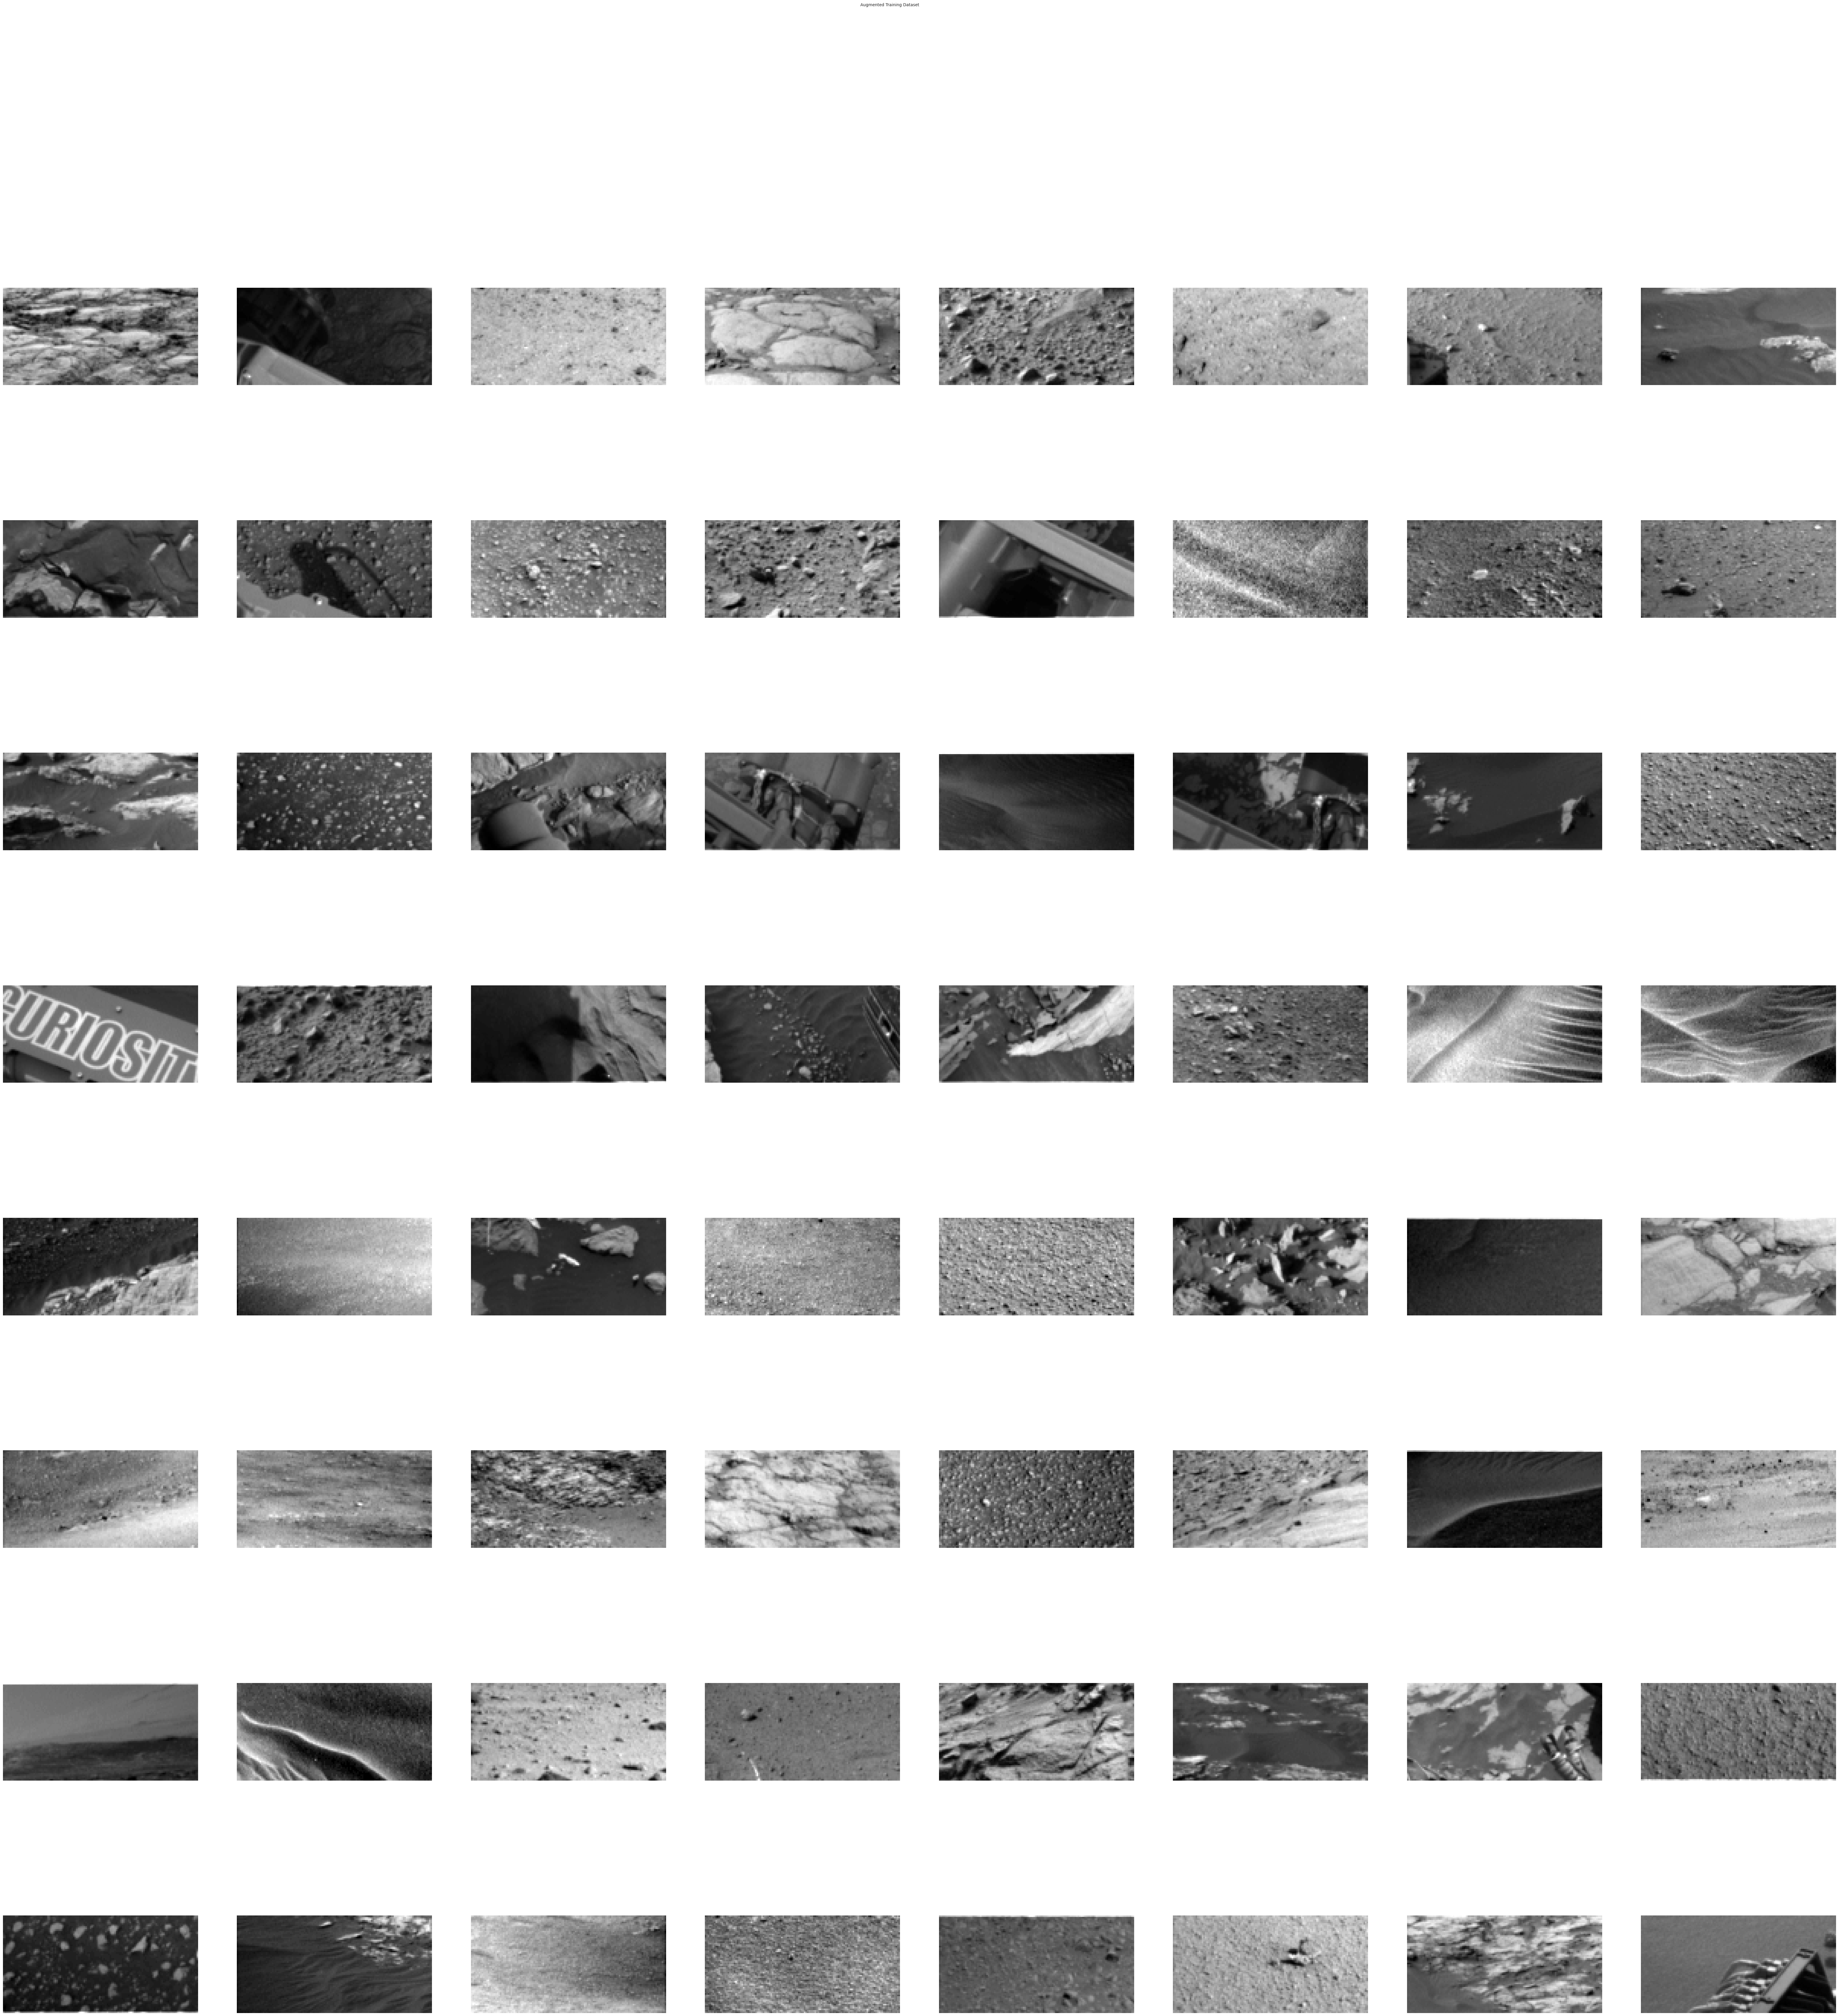

In [3]:
def visualize_dataset(dataset, title, image_size=(10, 10), grid_size=(8, 8)):
    print("Training set images:", len(dataset))

    num_images_to_plot = grid_size[0] * grid_size[1]
    random_indices = random.sample(range(len(dataset)), num_images_to_plot)
    sampled_images = [dataset[i] for i in random_indices]
    
    figsize = (grid_size[1] * image_size[0], grid_size[0] * image_size[1])
    plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=10)
    for i, image in enumerate(sampled_images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image, cmap="gray")  # Grayscale visualization
        plt.axis("off")
    plt.show()

visualize_dataset(X_train_val, "Augmented Training Dataset")

## 👽 Detect Outliers

In [4]:
# Function to calculate the hash of an image
def calculate_image_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

# Calculate hashes for each image and store their indices
hash_dict = defaultdict(list)
for idx, image in enumerate(y_train_val):
    img_hash = calculate_image_hash(image)
    hash_dict[img_hash].append(idx)

Duplicate images found!


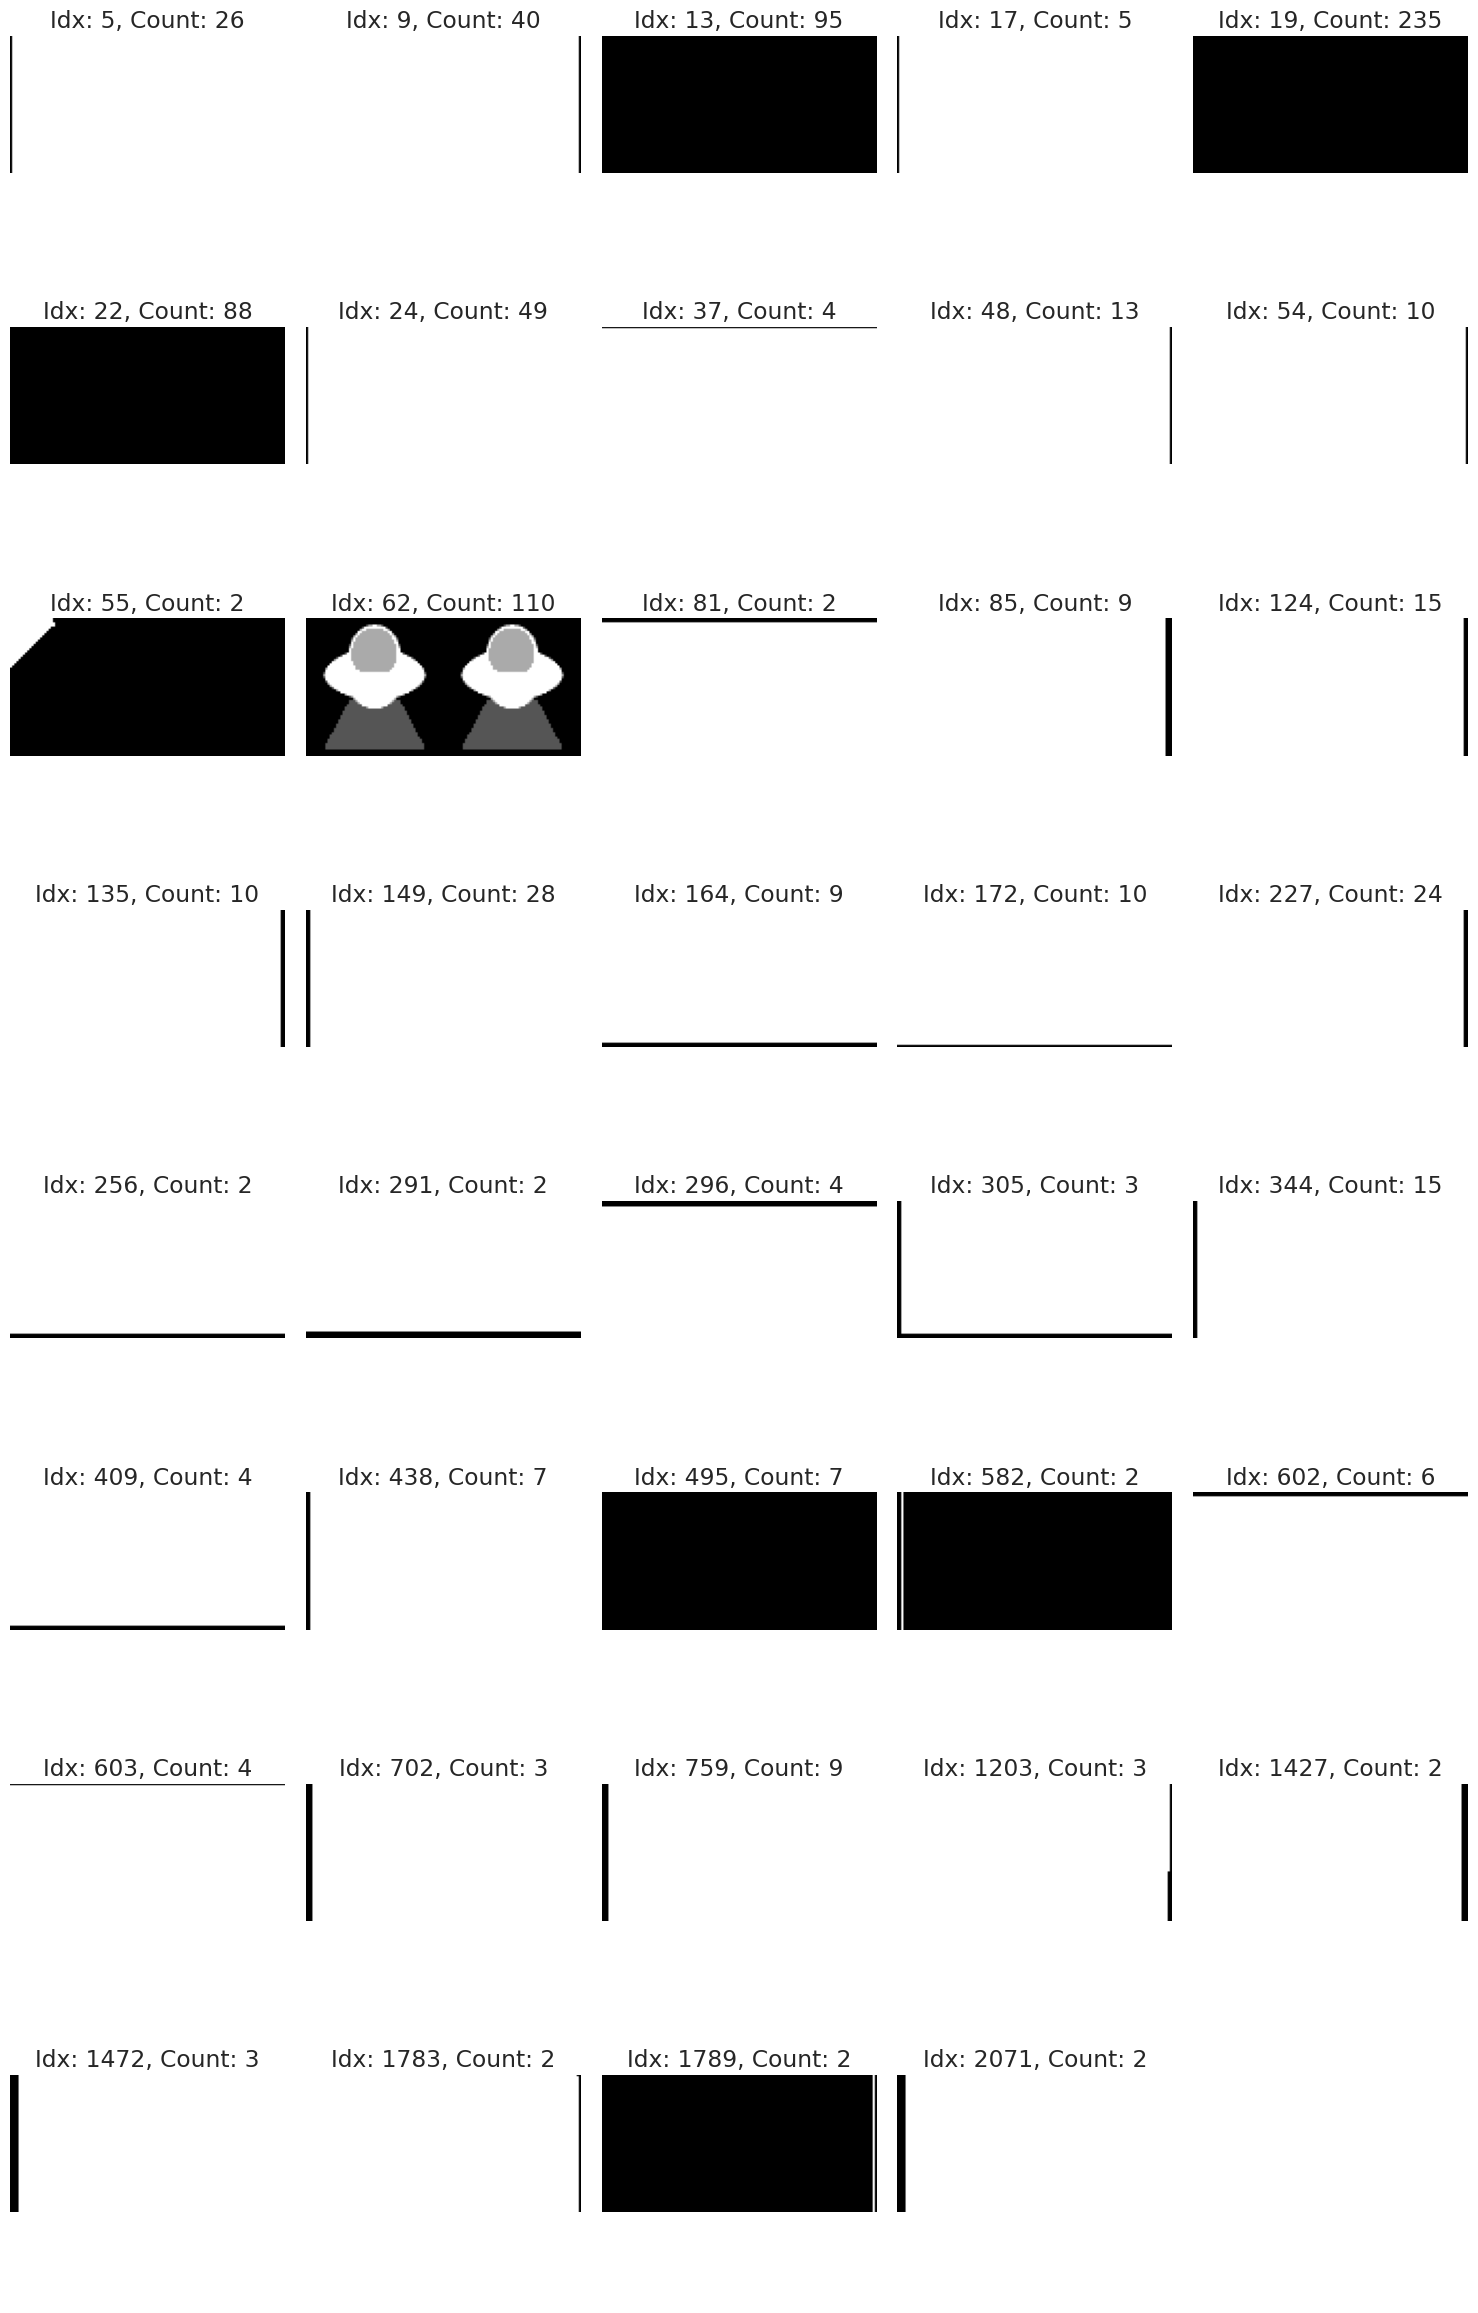

In [5]:
# Find duplicates
duplicates = {key: indices for key, indices in hash_dict.items() if len(indices) > 1}

if duplicates:
    print("Duplicate images found!")
   
    num_duplicates = len(duplicates)
    cols = 5 
    rows = (num_duplicates + cols - 1) // cols  
    
    # Create the figure and subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten()  
    
    for i, (img_hash, indices) in enumerate(duplicates.items()):
        # Select one representative image
        representative_idx = indices[0]
        occurrence_count = len(indices)  
        ax = axes[i]
        
        # Plot the image
        if y_train_val[representative_idx].ndim == 3: 
            ax.imshow(y_train_val[representative_idx])
        else: 
            ax.imshow(y_train_val[representative_idx], cmap='gray')
        
        # Set title with hash, occurrences, and first index
        ax.set_title(f"Idx: {representative_idx}, Count: {occurrence_count}")
        ax.axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

else:
    print("No duplicate images found!")

## Inspect an index

In [6]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

In [7]:
def apply_colormap(label, colormap=None):
    
    # Ensure label is 2D
    label = np.squeeze(label)

    # Ensure label values are in the valid range [0, num_classes-1]
    num_classes = len(colormap)  # Get the number of classes from the colormap
    label = np.clip(label, 0, num_classes - 1)  # Clip values to be within range

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

Hash for image at index 2071: 17fec901f6ed4082a70668bf7a334b37


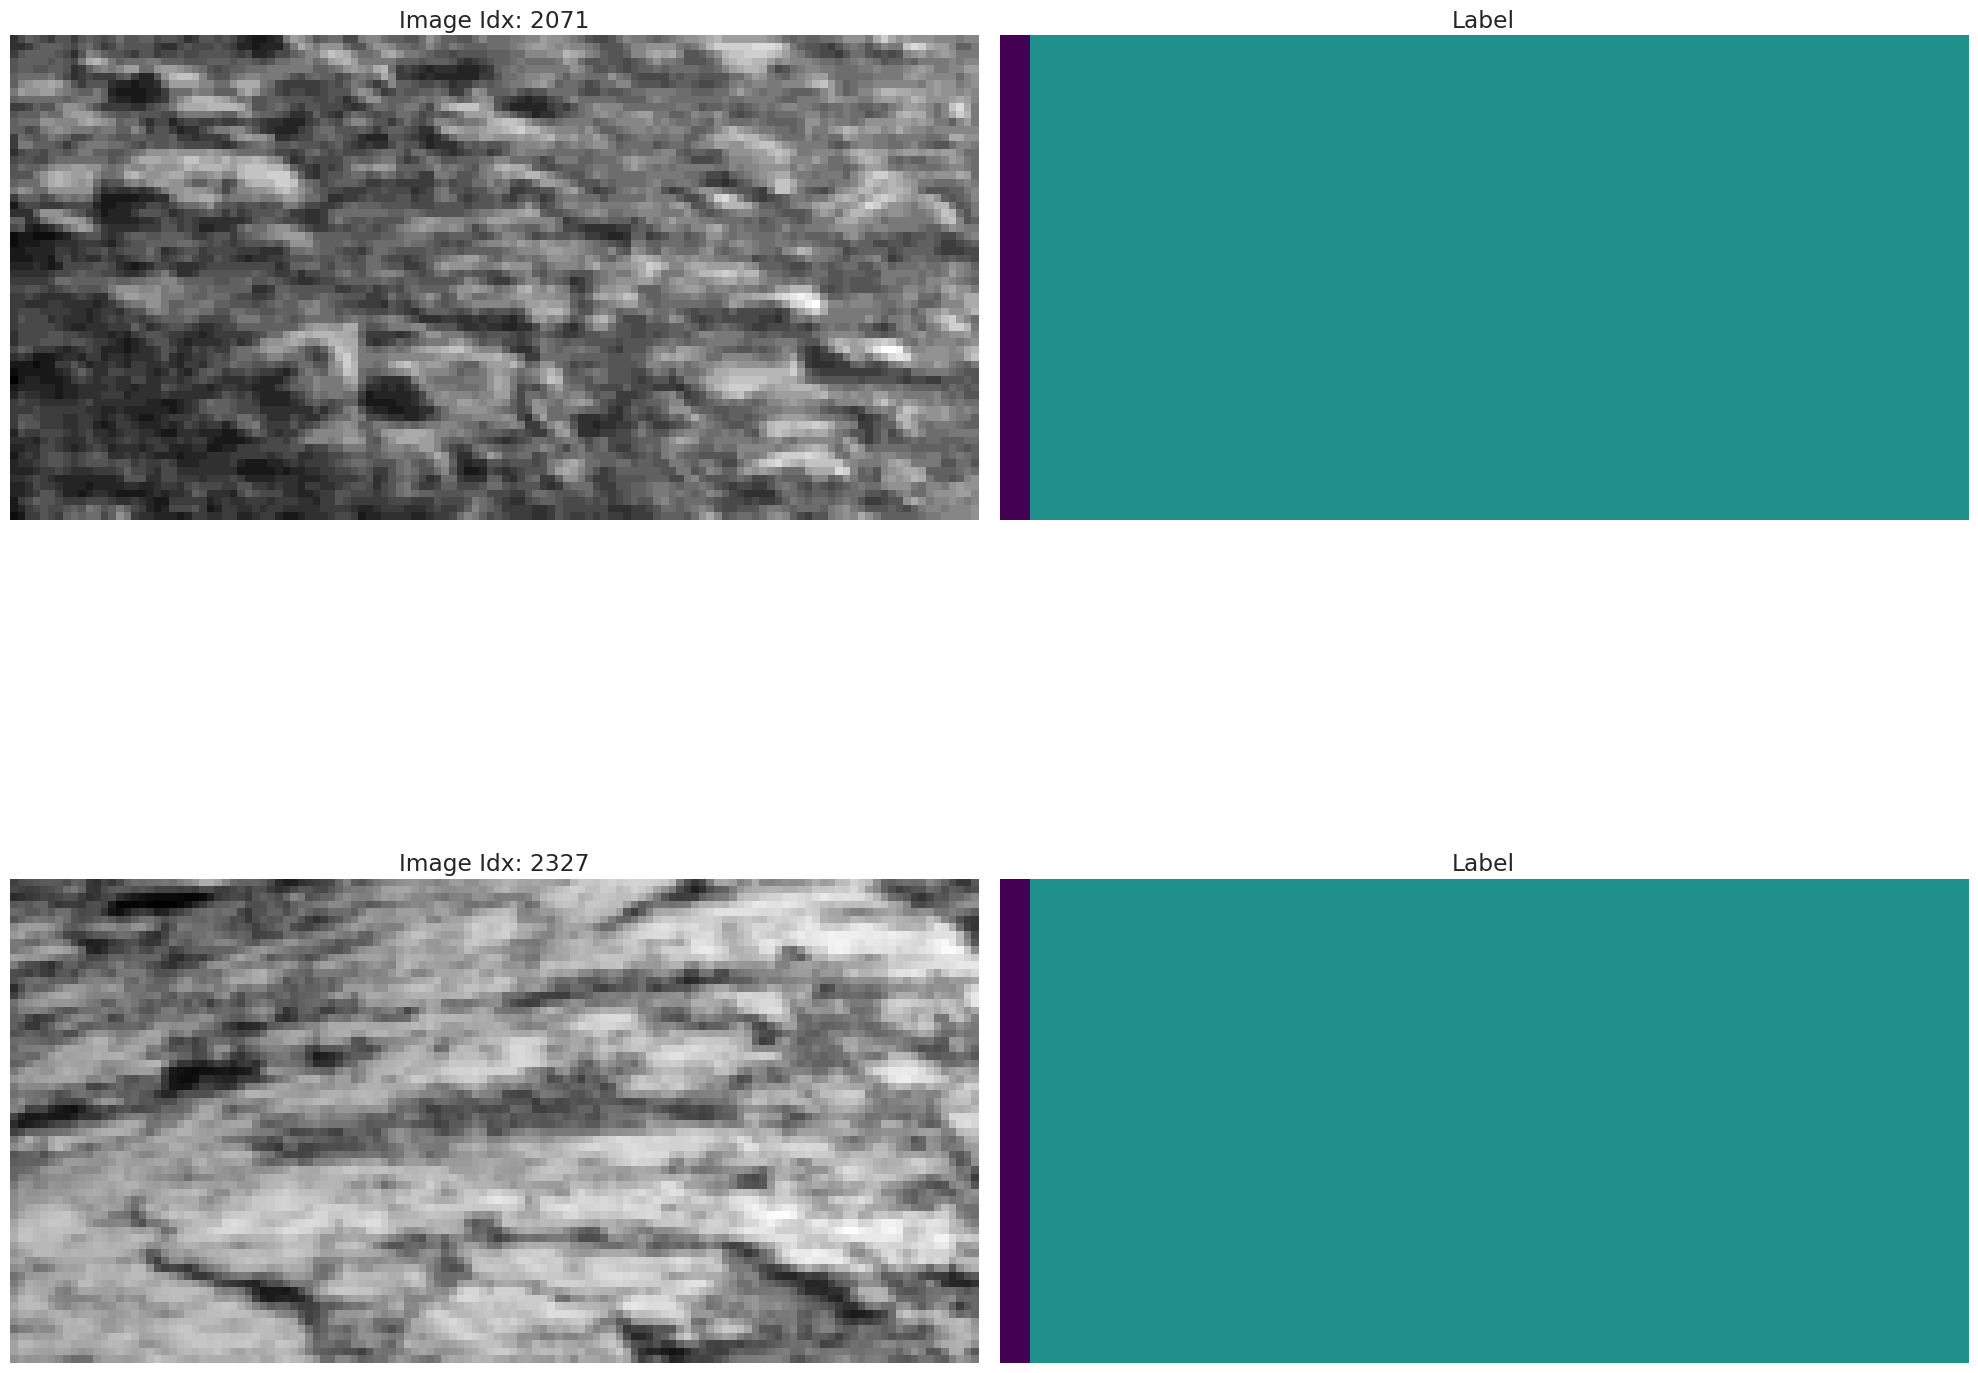

In [8]:
index_of_interest = 2071

# Function to get images associated with a specific index
def get_images_by_index(index):
    img_hash = calculate_image_hash(y_train_val[index])  # Calculate hash
    associated_indices = hash_dict.get(img_hash, [])  # Get duplicate indices
    return img_hash, associated_indices

# Get images and duplicates
img_hash, associated_indices = get_images_by_index(index_of_interest)

if associated_indices:
    print(f"Hash for image at index {index_of_interest}: {img_hash}")
    
    num_images = len(associated_indices)
    cols = 2  # Show image and label side-by-side
    rows = num_images  # One row per image-label pair
    
    # Create colormap for labels
    num_classes = len(np.unique(y_train_val))
    colormap = create_segmentation_colormap(num_classes)

    # Larger figure size for better visuals
    fig, axes = plt.subplots(rows, cols, figsize=(20, 10 * rows))
    axes = axes.reshape(rows, cols)  # Ensure axes is 2D for easy access

    for i, idx in enumerate(associated_indices):
        # Plot the image
        ax_image = axes[i, 0]
        ax_image.imshow(X_train_val[idx], cmap='gray' if X_train_val[idx].ndim == 2 else None)
        ax_image.set_title(f"Image Idx: {idx}")
        ax_image.axis('off')

        # Plot the label
        ax_label = axes[i, 1]
        colored_label = apply_colormap(y_train_val[idx], colormap)
        ax_label.imshow(colored_label)
        ax_label.set_title("Label")
        ax_label.axis('off')


    plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust spacing
    plt.tight_layout()
    plt.show()

else:
    print(f"No duplicates found for image at index {index_of_interest}.")


In [9]:
alien_index = 62

# Get associated indices
img_hash, alin_associated_indices = get_images_by_index(alien_index)

if(X_train_val.shape[0] == 2615):
    X_train_val = np.delete(X_train_val, alin_associated_indices, axis=0)
    y_train_val = np.delete(y_train_val, alin_associated_indices, axis=0)
    print("Outliers removed")
else:
    print("Outliers already removed")

print("Dataset dimension:", X_train_val.shape)

Outliers removed
Dataset dimension: (2505, 64, 128)


## 🔄 Process Data

In [10]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 150

# Set data split size for training and validation
SPLITS_SIZE = 0.2

## dividing in train and validaiton set

In [11]:
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)

# Display dataset information
print(f"\nNumber of images:")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")
print(f"Test set: {len(X_test)}")


Number of images:
Training set: 2004
Validation set: 501
Test set: 10022


In [12]:
# Define the category mapping
category_map = {
        0: 0,  # background
        1: 1,  # soil
        2: 2,  # bedrock
        3: 3,  # sand
        4: 4   # big rock
}

# Define the classes 
classes = ['background', 'soil', 'bedrock', 'sand', 'big rock'] 

NUM_CLASSES = len(set(category_map.values()))
print(f"Number of categories: {len(category_map)}")

Number of categories: 5


## normalizing the data

In [13]:
def preprocess_data(X, y, input_size=(64, 128)):
    X = tf.expand_dims(X, axis=-1)  
    X = tf.image.resize(X, input_size)
    X = tf.cast(X, tf.float32) / 255.0

    y = tf.expand_dims(y, axis=-1)
    y = tf.image.resize(y, input_size, method='bilinear')
    y = tf.cast(y, tf.int32)
    return X, y

# preprocessing also the test set
X_test = X_test[..., np.newaxis] / 255.0

In [14]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

## defining augmentation

In [15]:

# Define augmentation
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


In [16]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a TensorFlow dataset. 
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Preprocess immages and labels
    dataset = dataset.map(
        preprocess_data,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping: change the labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment: #apply random flip
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data (do it now and not at training time)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [17]:
# Create the datasets
train_dataset = make_dataset(
    X_train, y_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False 
)

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


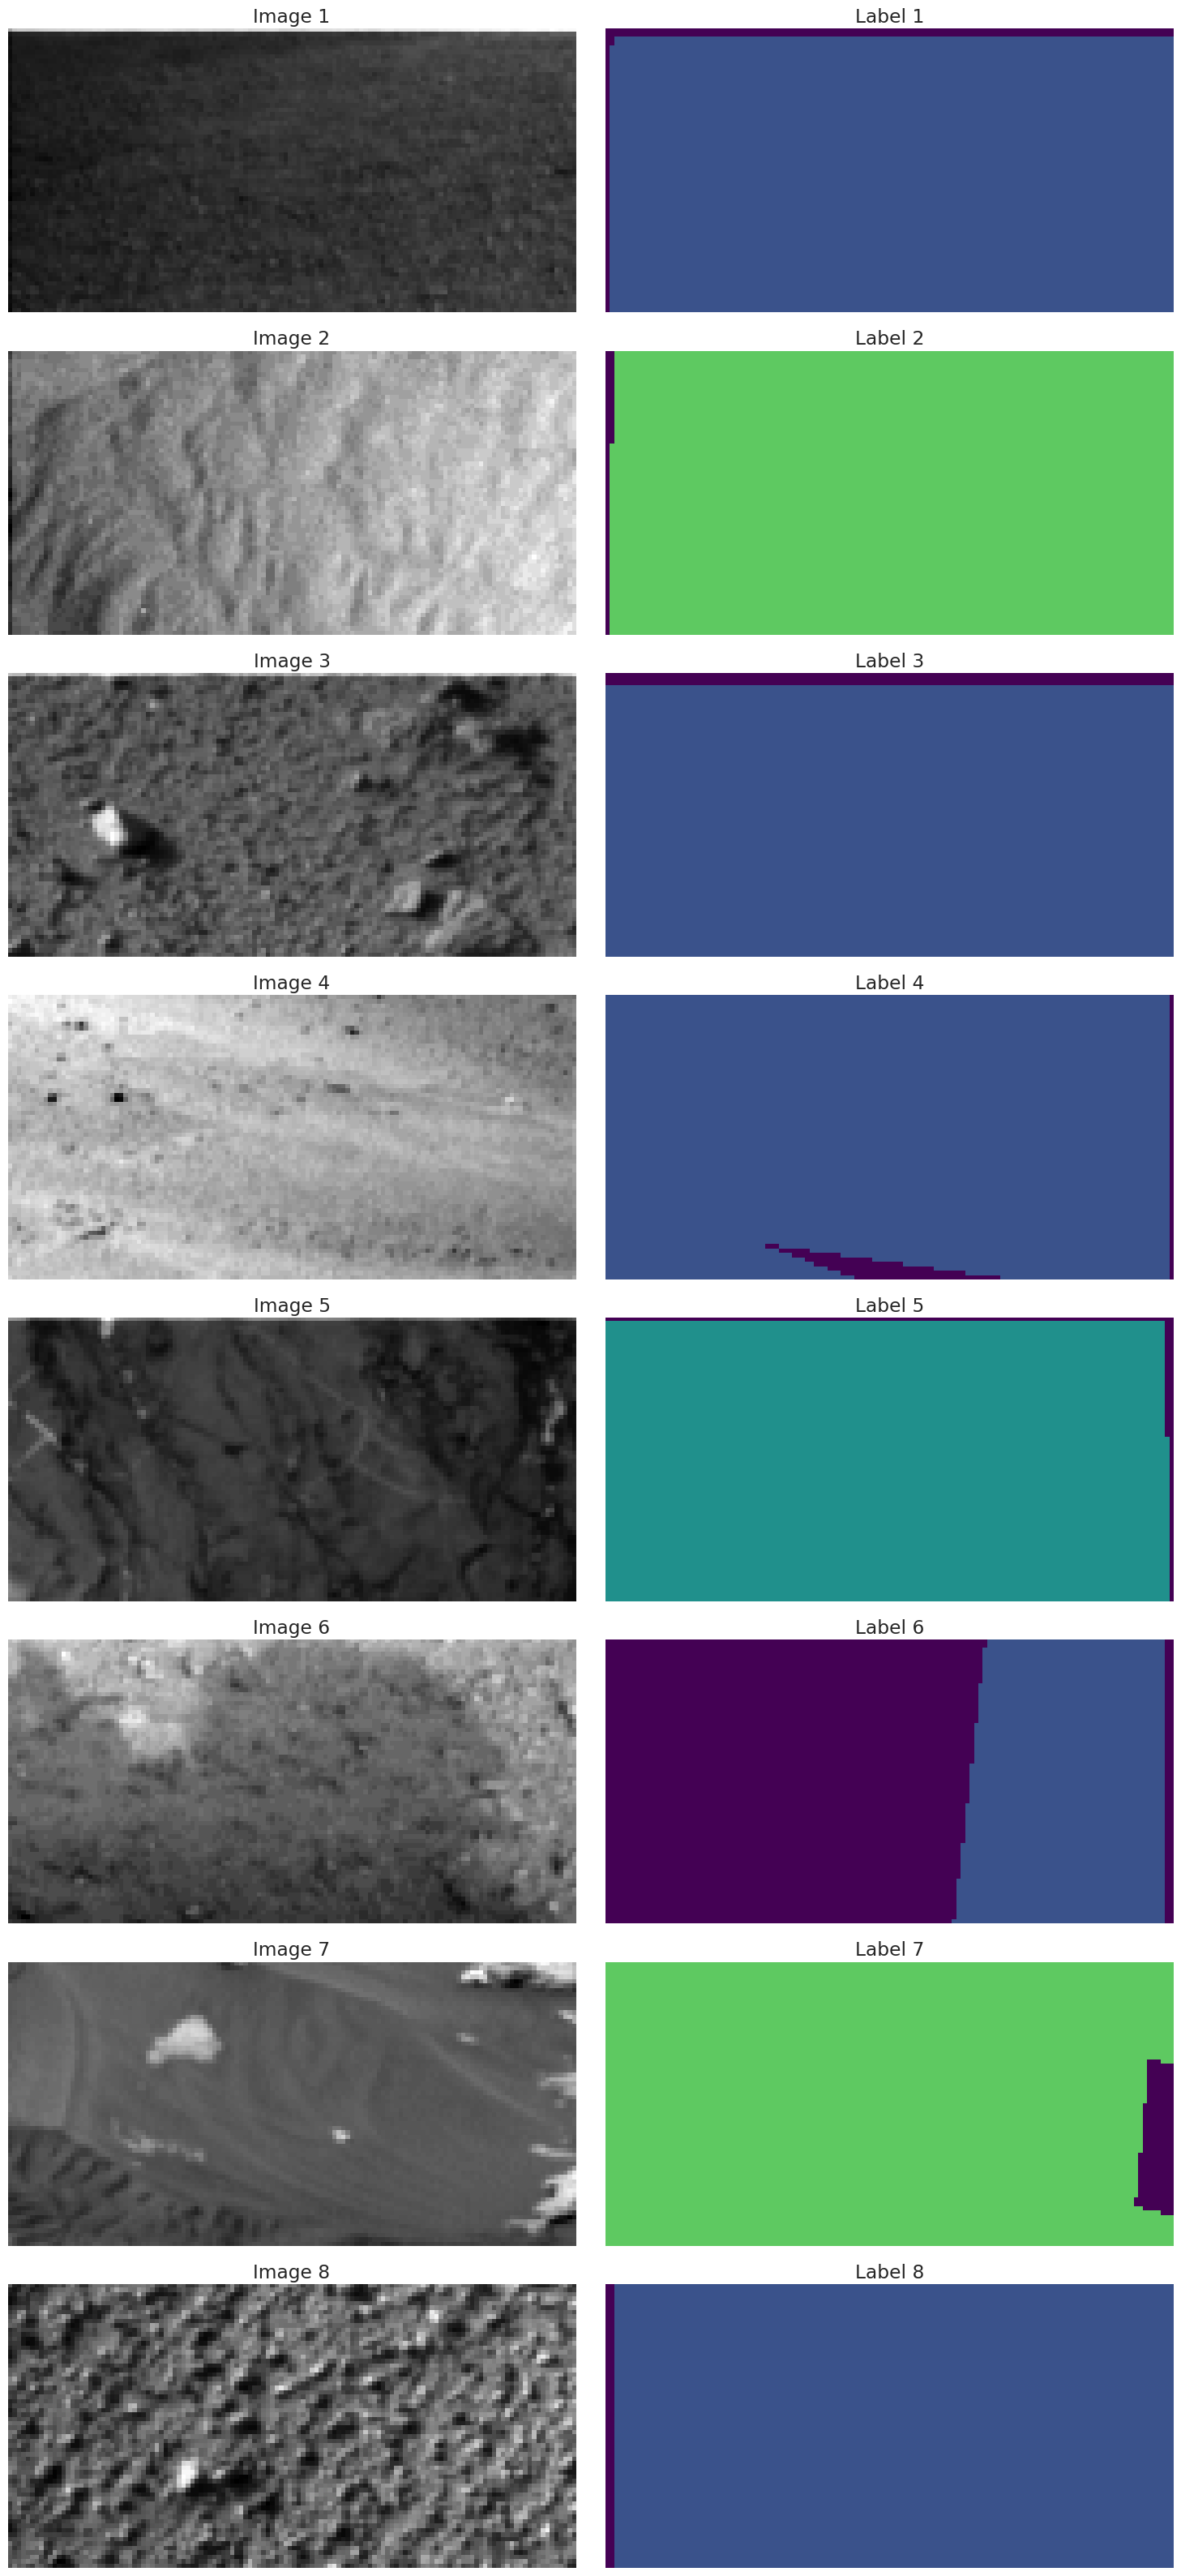

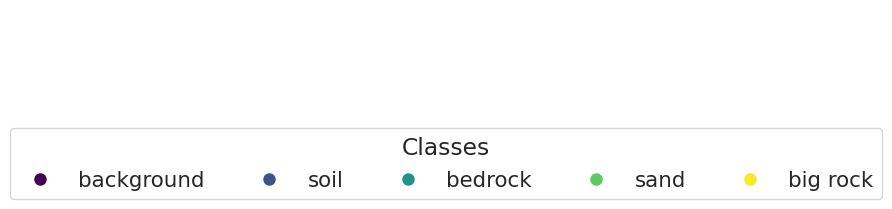

In [18]:
# Plot real image and ground truth (reduced resolution)
def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4 * num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(category_map)  # Ensure colormap covers all classes, including the background
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original grayscale image (no colormap)
            plt.subplot(num_samples, 2, j * 2 + 1)
            plt.imshow(images[j], cmap='gray')  # Use 'gray' cmap for the images (ensure grayscale)
            plt.title(f'Image {j + 1}')
            plt.axis('off')

            # Plot colored label (apply colormap only to labels)
            plt.subplot(num_samples, 2, j * 2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)  # Apply colormap to the labels only
            plt.imshow(colored_label)  # Show the colored label
            plt.title(f'Label {j + 1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

    handles = []
    # After all images have been plotted, add the legend once
    for label_idx in category_map:
        color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))
    
    # Create a single legend displayed at the bottom
    fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
    ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
    ax.axis('off')
    plt.show()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=8)

## 🛠️ Model Definition and Training

In [19]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [20]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')  # first block with 32 filters
    d1 = tfkl.MaxPooling2D()(down_block_1)  # reduce spatial complexity

    down_block_2 = unet_block(d1, 64, name='down_block2_')  # second block with 64 filters
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # third block with 128 filters
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # added block with 256 filters
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck with 512 filters
    bottleneck = unet_block(d4, 512, name='bottleneck')  # bottleneck with 512 filters

    # Upsampling path: increase spatial complexity
    u1 = tfkl.UpSampling2D()(bottleneck)  # Upsampling layer
    u1 = tfkl.Concatenate()([u1, down_block_4])  # Skip connection from downsampling path
    u1 = unet_block(u1, 256, name='up_block1_')  # first upsampling block with 256 filters

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 128, name='up_block2_')  # second upsampling block with 128 filters

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 64, name='up_block3_')  # third upsampling block with 64 filters

    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 32, name='up_block4_')  # fourth upsampling block with 32 filters

    # Output Layer: final convolution with softmax activation for segmentation
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │       512 │ down_block3_c… │   Y 

 Total params: 7,857,989 (29.98 MB)

 Trainable params: 7,852,101 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

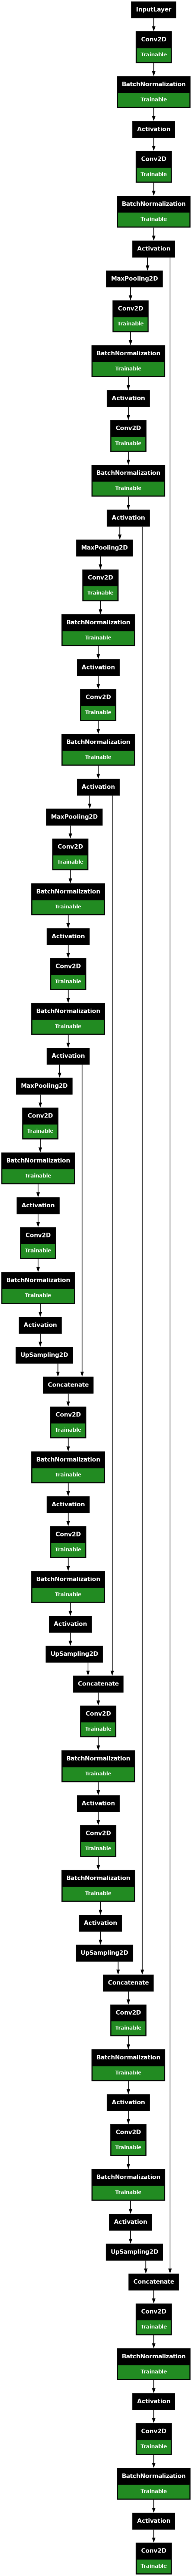

In [21]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, dpi=70)

In [22]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback: plot during the training the prediction and the images
#useful for debugging ex. I'm stuck in a local minima where the less represented class is never predicted
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, frequency=5):
        super().__init__()
        self.val_dataset = val_dataset  # The validation dataset
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            # Get a batch from the validation dataset
            for image_batch, label_batch in self.val_dataset.take(1):
                for i in range(2):
                    idx = 0 if i==0 else 14
                    image = image_batch[idx]  # Take the first image from the batch (oppure 13)
                    label = label_batch[idx]  # Take the first label from the batch
    
                    # Add batch dimension to the image (if necessary)
                    image = tf.expand_dims(image, 0)
    
                    # Perform prediction
                    pred = self.model.predict(image, verbose=0)
                    y_pred = tf.math.argmax(pred, axis=-1)
                    y_pred = y_pred.numpy()  # Convert to NumPy array for visualization
    
                    # Create colormap (assuming a predefined function `create_segmentation_colormap`)
                    num_classes = NUM_CLASSES
                    colormap = create_segmentation_colormap(num_classes)
    
                    # Plot the results
                    plt.figure(figsize=(16, 4))
    
                    # Input image
                    plt.subplot(i+1, 3, 1)
                    plt.imshow(image[0], cmap='gray')
                    plt.title("Input Image")
                    plt.axis('off')
    
                    # Ground truth
                    plt.subplot(i+1, 3, 2)
                    colored_label = apply_colormap(label.numpy(), colormap)  # Assuming `apply_colormap` is defined
                    plt.imshow(colored_label)
                    plt.title("Ground Truth Mask")
                    plt.axis('off')
    
                    # Prediction
                    plt.subplot(i+1, 3, 3)
                    colored_pred = apply_colormap(y_pred[0], colormap)  # Apply colormap to prediction
                    plt.imshow(colored_pred)
                    plt.title("Predicted Mask")
                    plt.axis('off')

                    plt.tight_layout()
                plt.show()
                plt.close()

### class weights

In [23]:
y_train_flatt = y_train.flatten()

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_flatt),
    y=y_train_flatt
)

class_weights = dict(enumerate(class_weights)) 
print("Class weights:", class_weights)

Class weights: {0: 0.8249853953360052, 1: 0.5935027933021484, 2: 0.8366099618482732, 3: 1.1096943312319119, 4: 153.93846875146514}


#### Boundary Loss

In [24]:
# Boudary Loss as expose (SurfaceLoss) in https://github.com/LIVIAETS/boundary-loss/blob/master/losses.py
# code related to https://arxiv.org/abs/1812.07032

class BoundaryLoss(tf.keras.losses.Loss):
    def __init__(self, idc, **kwargs):
        """
        Boundary Loss implementation in TensorFlow.
        Args:
            idc (List[int]): List of class indices to filter out in the target mask.
        """
        super().__init__(**kwargs)
        self.idc = idc  # Classes to exclude
        print(f"Initialized {self.__class__.__name__} with idc={idc}")

    def call(self, probs, dist_maps):
        """
        Compute the boundary loss.
        Args:
            probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes, height, width).
            dist_maps (tf.Tensor): Distance maps, shape (batch_size, num_classes, height, width).
        
        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure the inputs are valid
        tf.debugging.assert_less_equal(tf.reduce_max(probs), 1.0, "Probs are not simplex (values > 1)")
        tf.debugging.assert_greater_equal(tf.reduce_min(probs), 0.0, "Probs are not simplex (values < 0)")

        # Exclude the specified classes
        all_classes = tf.range(probs.shape[1])  # All class indices
        include_classes = tf.boolean_mask(all_classes, ~tf.reduce_any(all_classes[..., None] == self.idc, axis=-1))

        # Select only the included classes
        pc = tf.gather(probs, include_classes, axis=1)
        dc = tf.gather(dist_maps, include_classes, axis=1)

        # Perform element-wise multiplication
        multiplied = tf.multiply(pc, dc)

        # Compute mean loss
        loss = multiplied

        return loss

### Dynamic multi-loss

In [25]:
SCCE = tf.keras.losses.SparseCategoricalCrossentropy()
Dice = tf.keras.losses.Dice()
Boundary = BoundaryLoss(idc=[0])

'''
adjusts the weights based on the epoch number, 
reducing the Focal loss weight and increasing the Dice loss weight as training progresses.
'''

class DynamicLoss(tf.keras.losses.Loss):
    def __init__(self, **kwargs):
        super(DynamicLoss, self).__init__(**kwargs)
        self.initial_dice_weight = 0.4
        self.initial_scce_weight = 0.4
        self.initial_boundary_weight = 0.2
        
        self.scce_weight = self.initial_scce_weight
        self.dice_weight = self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight

    def update_weights(self, epoch):
        total_epochs = EPOCHS
        epoch_factor = epoch / total_epochs
        
        # Adjust weights dynamically
        self.scce_weight = self.initial_scce_weight + epoch_factor * (1 - self.initial_scce_weight)
        self.dice_weight = self.initial_dice_weight - epoch_factor * self.initial_dice_weight
        self.boundary_weight = self.initial_boundary_weight + epoch_factor * (1 - self.initial_boundary_weight)
        
        # Normalize weights so they sum to 1
        total_weight = self.scce_weight +  self.dice_weight + self.boundary_weight
        self.scce_weight /= total_weight
        self.dice_weight /= total_weight
        self.boundary_weight /= total_weight

        print(f"SCCE weight: {self.scce_weight:.4f}, "
              f"Dice weight: {self.dice_weight:.4f}, "
              f"Boundary weight: {self.boundary_weight:.4f}")

    def call(self, y_true, y_pred):

        y_true = tf.cast(y_true, tf.int32)  # Make sure y_true is of type int32
        y_true = tf.squeeze(y_true, axis=-1)  # Remove any extra dimensions (like [batch_size, height, width, 1])
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # Convert to one-hot encoding
        y_true = tf.cast(y_true, tf.float32)
        
        # evaluating weights based on classes
        class_weights_tensor = tf.constant([class_weights[key] for key in sorted(class_weights.keys())], dtype=tf.float32)
        weights = tf.reduce_sum(class_weights_tensor * y_true, axis=-1)

        # Calculate individual losses
        y_true_indices = tf.argmax(y_true, axis=-1) # categorical cross entropy expect a y_true with y_prede_dim-1
        SCCE_value = SCCE(y_true_indices, y_pred, sample_weight=weights)
        
        Dice_value = Dice(y_true, y_pred)
        Boundary_value = Boundary(y_true, y_pred)

        # Combine losses
        total_loss = self.scce_weight * SCCE_value + self.dice_weight * Dice_value + self.boundary_weight * Boundary_value
        return tf.reduce_mean(total_loss)

Initialized BoundaryLoss with idc=[0]


In [26]:
class EpochTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EpochTracker, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch 
        self.model.loss.update_weights(epoch)
        
    def get_epoch(self):
        return getattr(self, 'epoch', 0) 

In [27]:
# Compile the model
dynamic_loss = DynamicLoss()
# keep track of the epochs for the dynamic_loss updates
epoch_tracker = EpochTracker()

model.compile(
    loss=dynamic_loss, 
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [28]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

learning_rate = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou', 
    factor=0.1, 
    patience=15, 
    min_delta=1e-5,
    mode='max'
)

viz_callback = VizCallback(val_dataset, frequency=5)

SCCE weight: 0.4000, Dice weight: 0.4000, Boundary weight: 0.2000
Epoch 1/150


I0000 00:00:1733400595.678690      73 service.cc:145] XLA service 0x7ee9f8004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733400595.678765      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733400595.678773      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1733400601.684376      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733400601.686734      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733400601.689395      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
I0000 00:00:1733400630.999405      73 device_compiler.h:188] Comp

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3164 - loss: 1.0030 - mean_iou: 0.1680

W0000 00:00:1733400638.798738      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733400638.800535      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733400638.802161      73 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.3173 - loss: 1.0013 - mean_iou: 0.1687

W0000 00:00:1733400661.555263      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733400661.557895      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733400661.560676      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_greater_equal/Assert/AssertGuard/Assert
W0000 00:00:1733400667.928442      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733400667.929914      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynamic_loss/boundary_loss/assert_less_equal/Assert/AssertGuard/Assert
W0000 00:00:1733400667.931350      75 assert_op.cc:38] Ignoring Assert operator compile_loss/dynami

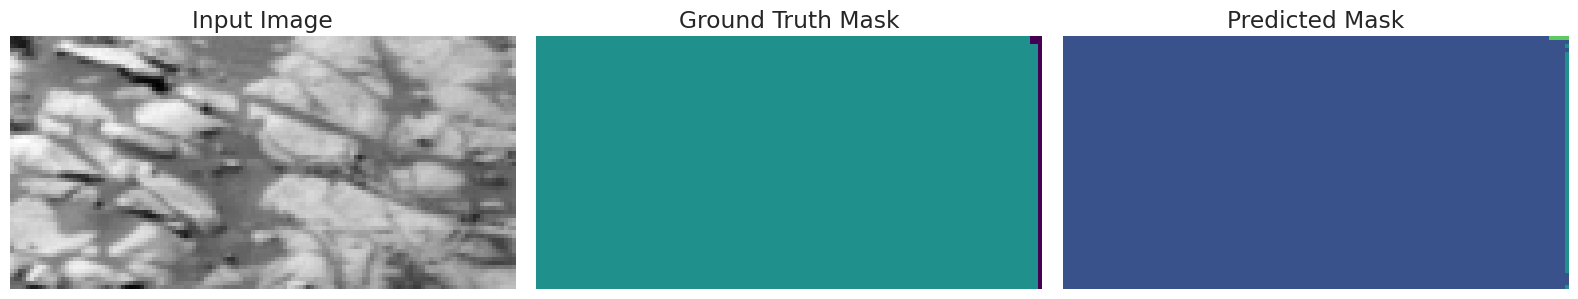

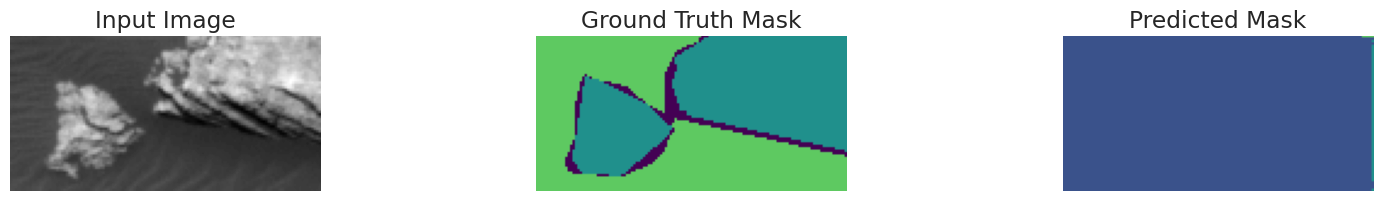

32/32 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.3181 - loss: 0.9997 - mean_iou: 0.1694 - val_accuracy: 0.3466 - val_loss: 8.1295 - val_mean_iou: 0.1164 - learning_rate: 0.0010
SCCE weight: 0.4013, Dice weight: 0.3947, Boundary weight: 0.2040
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.3869 - loss: 0.8553 - mean_iou: 0.2147 - val_accuracy: 0.1979 - val_loss: 1.4377 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4026, Dice weight: 0.3895, Boundary weight: 0.2079
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.4724 - loss: 0.7591 - mean_iou: 0.2746 - val_accuracy: 0.1979 - val_loss: 2.4391 - val_mean_iou: 0.0525 - learning_rate: 0.0010
SCCE weight: 0.4039, Dice weight: 0.3843, Boundary weight: 0.2118
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.5321 - loss: 0.7183 - mean_iou: 0.3061 - val_accuracy: 0.2441 - val_loss: 3.4646 - val_mean_iou: 0.0015 - learning_rate: 0.0010
SCCE weight: 0.4052, Dice weight: 0.

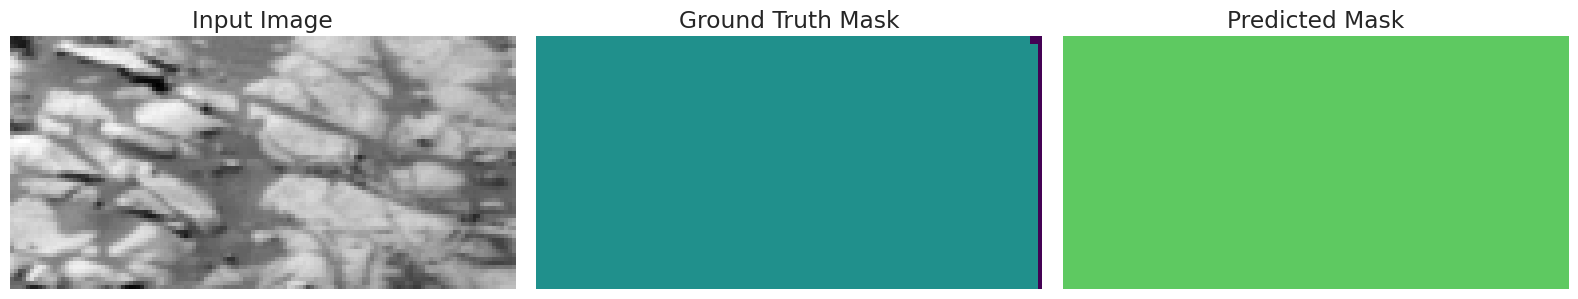

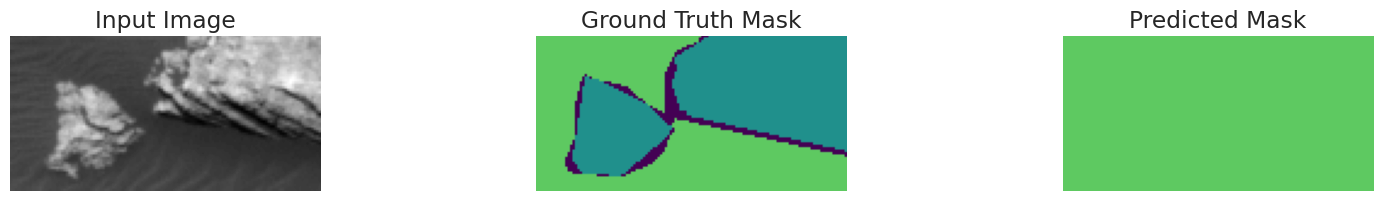

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.5331 - loss: 0.7493 - mean_iou: 0.2985 - val_accuracy: 0.1979 - val_loss: 3.1591 - val_mean_iou: 0.0525 - learning_rate: 0.0010
SCCE weight: 0.4077, Dice weight: 0.3692, Boundary weight: 0.2231
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.5264 - loss: 0.7205 - mean_iou: 0.3186 - val_accuracy: 0.1979 - val_loss: 3.0067 - val_mean_iou: 0.0656 - learning_rate: 0.0010
SCCE weight: 0.4089, Dice weight: 0.3643, Boundary weight: 0.2268
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.5736 - loss: 0.6698 - mean_iou: 0.3568 - val_accuracy: 0.1979 - val_loss: 2.3452 - val_mean_iou: 0.0525 - learning_rate: 0.0010
SCCE weight: 0.4101, Dice weight: 0.3595, Boundary weight: 0.2304
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5323 - loss: 0.7130 - mean_iou: 0.2989 - val_accuracy: 0.1979 - val_loss: 2.1833 - val_mean_iou: 0.0525 - learning_rate: 0.0010
SCCE weight: 0.4113, Dice weight: 

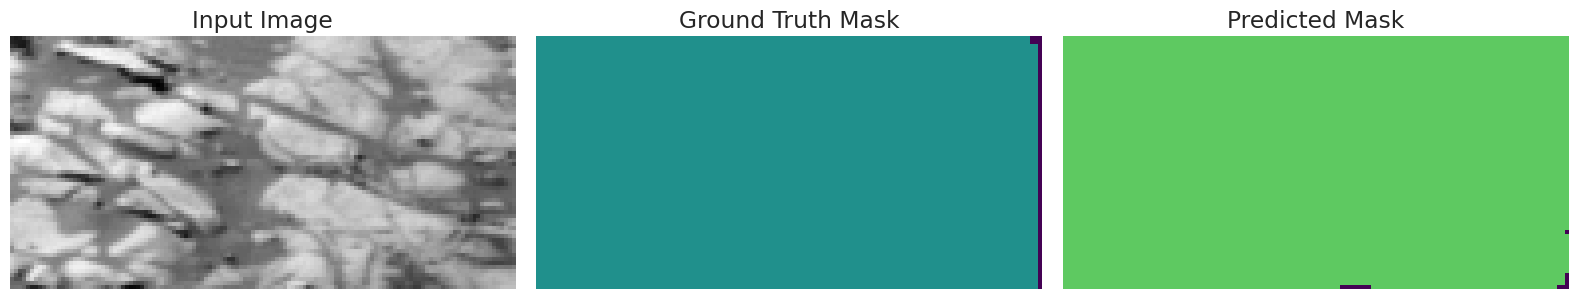

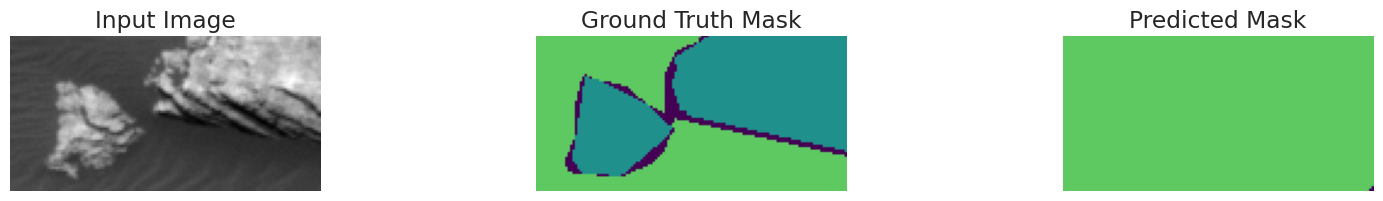

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 230ms/step - accuracy: 0.5717 - loss: 0.6953 - mean_iou: 0.3435 - val_accuracy: 0.2039 - val_loss: 1.9170 - val_mean_iou: 0.0524 - learning_rate: 0.0010
SCCE weight: 0.4137, Dice weight: 0.3453, Boundary weight: 0.2410
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.5812 - loss: 0.6405 - mean_iou: 0.3591 - val_accuracy: 0.2154 - val_loss: 1.6638 - val_mean_iou: 0.0475 - learning_rate: 0.0010
SCCE weight: 0.4148, Dice weight: 0.3407, Boundary weight: 0.2444
Epoch 13/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6308 - loss: 0.6043 - mean_iou: 0.3817 - val_accuracy: 0.2387 - val_loss: 1.7139 - val_mean_iou: 0.0365 - learning_rate: 0.0010
SCCE weight: 0.4160, Dice weight: 0.3362, Boundary weight: 0.2479
Epoch 14/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6267 - loss: 0.6032 - mean_iou: 0.3820 - val_accuracy: 0.2222 - val_loss: 1.5540 - val_mean_iou: 0.0441 - learning_rate: 0.0010
SCCE weight: 0.4171, Dice weigh

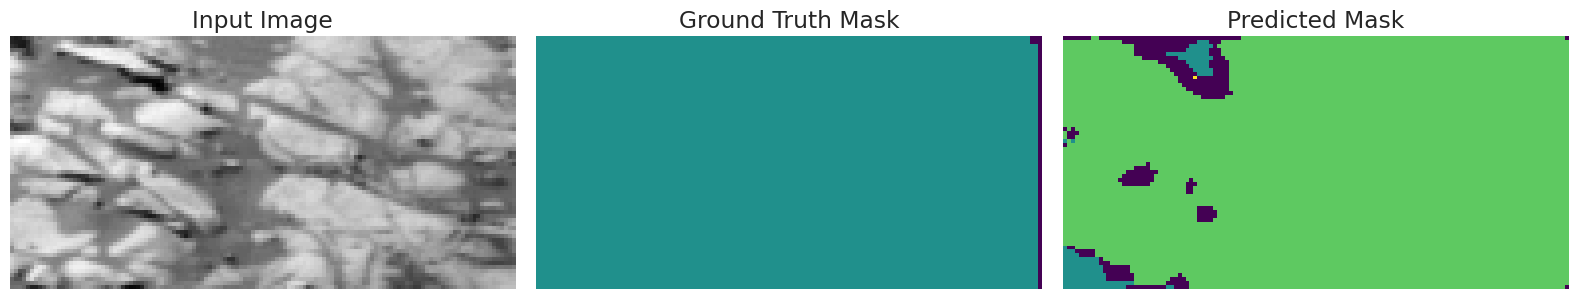

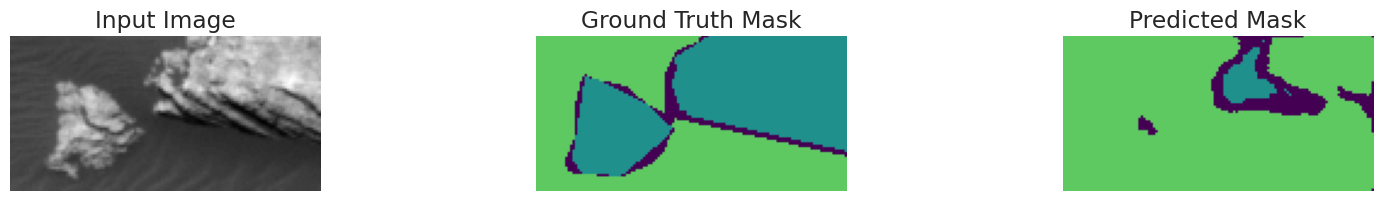

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.5817 - loss: 0.6412 - mean_iou: 0.3740 - val_accuracy: 0.2381 - val_loss: 1.5119 - val_mean_iou: 0.0843 - learning_rate: 0.0010
SCCE weight: 0.4193, Dice weight: 0.3229, Boundary weight: 0.2578
Epoch 17/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.6115 - loss: 0.6143 - mean_iou: 0.3971 - val_accuracy: 0.2695 - val_loss: 1.2792 - val_mean_iou: 0.1043 - learning_rate: 1.0000e-04
SCCE weight: 0.4204, Dice weight: 0.3186, Boundary weight: 0.2611
Epoch 18/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.6421 - loss: 0.5642 - mean_iou: 0.4192 - val_accuracy: 0.3178 - val_loss: 1.1426 - val_mean_iou: 0.1379 - learning_rate: 1.0000e-04
SCCE weight: 0.4214, Dice weight: 0.3143, Boundary weight: 0.2643
Epoch 19/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.6469 - loss: 0.5604 - mean_iou: 0.4205 - val_accuracy: 0.4297 - val_loss: 0.9485 - val_mean_iou: 0.2215 - learning_rate: 1.0000e-04
SCCE weight: 0.4225

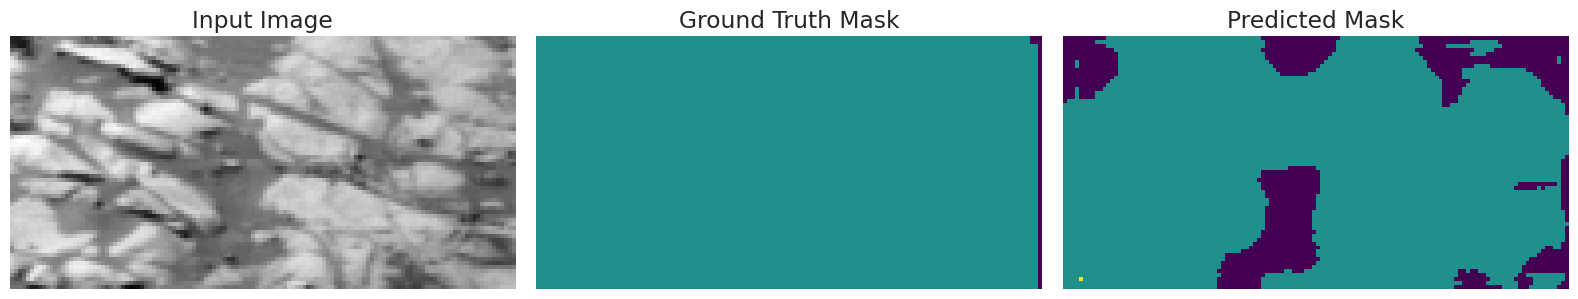

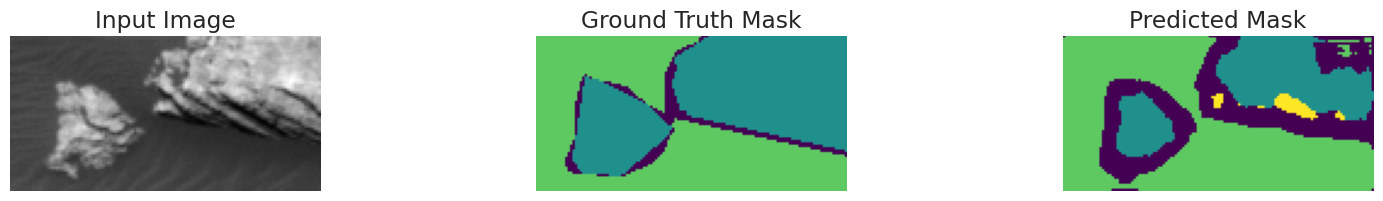

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.6602 - loss: 0.5448 - mean_iou: 0.4247 - val_accuracy: 0.5752 - val_loss: 0.7042 - val_mean_iou: 0.3336 - learning_rate: 1.0000e-04
SCCE weight: 0.4246, Dice weight: 0.3018, Boundary weight: 0.2737
Epoch 22/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.6674 - loss: 0.5413 - mean_iou: 0.4332 - val_accuracy: 0.6320 - val_loss: 0.6293 - val_mean_iou: 0.3817 - learning_rate: 1.0000e-04
SCCE weight: 0.4256, Dice weight: 0.2977, Boundary weight: 0.2767
Epoch 23/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.6708 - loss: 0.5388 - mean_iou: 0.4345 - val_accuracy: 0.6452 - val_loss: 0.5969 - val_mean_iou: 0.3961 - learning_rate: 1.0000e-04
SCCE weight: 0.4266, Dice weight: 0.2936, Boundary weight: 0.2798
Epoch 24/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.6710 - loss: 0.5351 - mean_iou: 0.4336 - val_accuracy: 0.6424 - val_loss: 0.5893 - val_mean_iou: 0.3934 - learning_rate: 1.0000e-04
SCCE weight: 0.

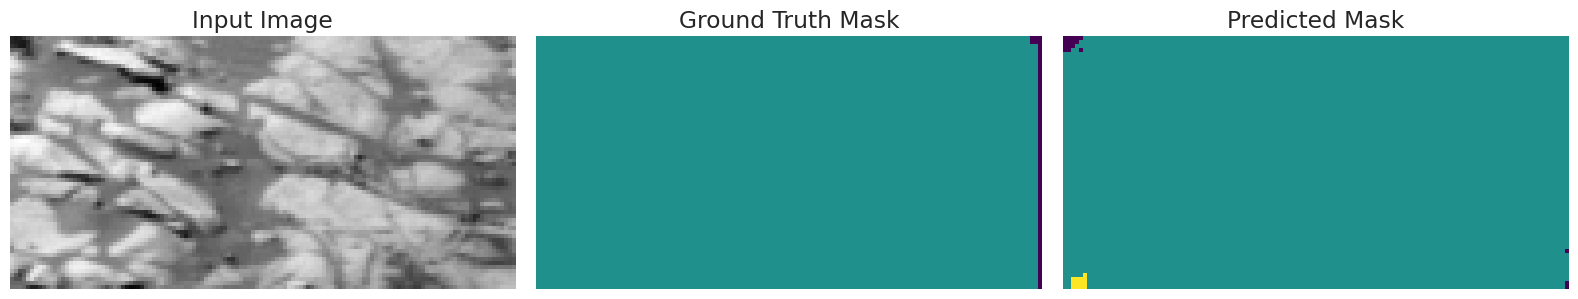

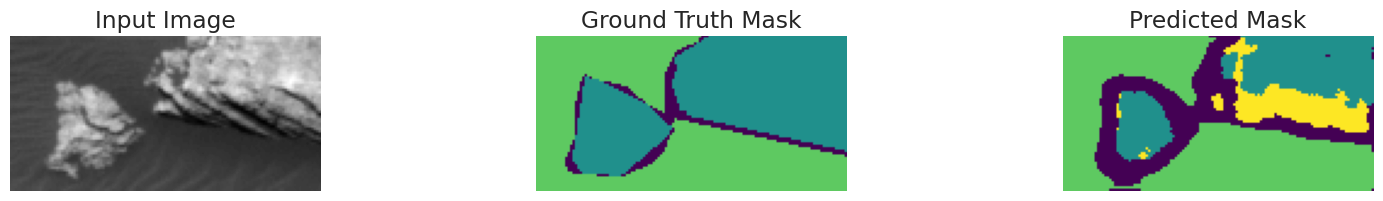

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.6856 - loss: 0.5180 - mean_iou: 0.4434 - val_accuracy: 0.6639 - val_loss: 0.5518 - val_mean_iou: 0.4147 - learning_rate: 1.0000e-04
SCCE weight: 0.4295, Dice weight: 0.2818, Boundary weight: 0.2886
Epoch 27/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.6809 - loss: 0.5085 - mean_iou: 0.4404 - val_accuracy: 0.6662 - val_loss: 0.5394 - val_mean_iou: 0.4104 - learning_rate: 1.0000e-04
SCCE weight: 0.4305, Dice weight: 0.2780, Boundary weight: 0.2915
Epoch 28/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.6827 - loss: 0.5073 - mean_iou: 0.4354 - val_accuracy: 0.6641 - val_loss: 0.5354 - val_mean_iou: 0.4087 - learning_rate: 1.0000e-04
SCCE weight: 0.4315, Dice weight: 0.2742, Boundary weight: 0.2944
Epoch 29/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.6875 - loss: 0.4973 - mean_iou: 0.4449 - val_accuracy: 0.6715 - val_loss: 0.5414 - val_mean_iou: 0.4156 - learning_rate: 1.0000e-04
SCCE weight: 0.

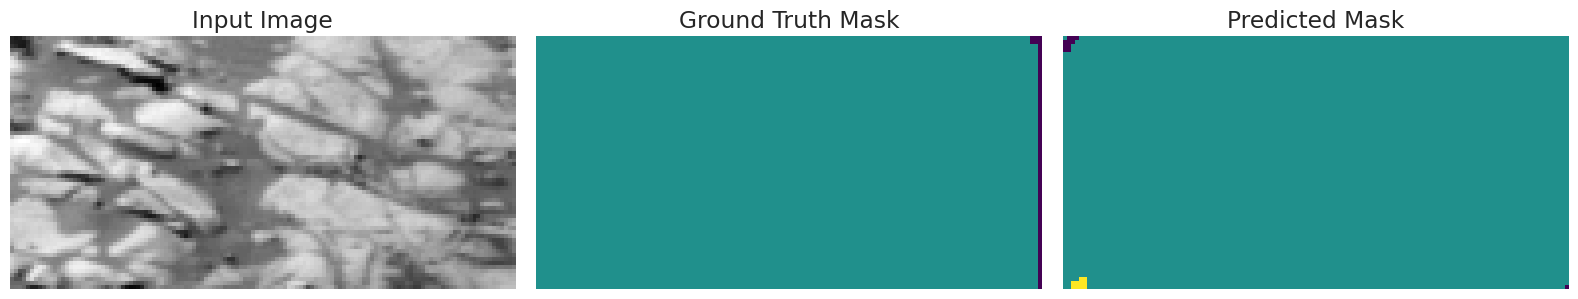

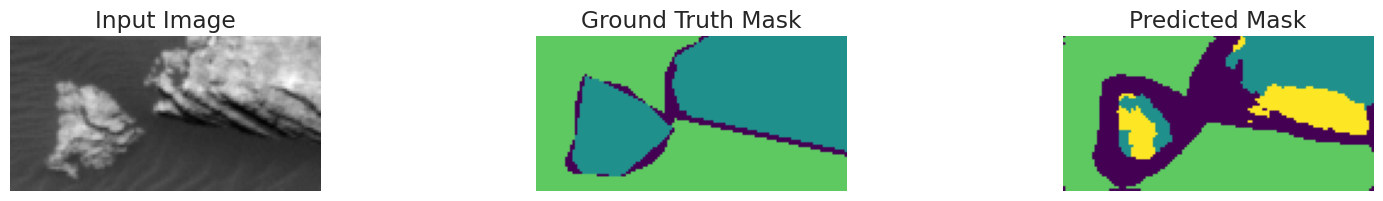

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.6933 - loss: 0.4889 - mean_iou: 0.4458 - val_accuracy: 0.7006 - val_loss: 0.5138 - val_mean_iou: 0.4408 - learning_rate: 1.0000e-04
SCCE weight: 0.4343, Dice weight: 0.2630, Boundary weight: 0.3028
Epoch 32/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.6977 - loss: 0.4940 - mean_iou: 0.4382 - val_accuracy: 0.6902 - val_loss: 0.5259 - val_mean_iou: 0.4385 - learning_rate: 1.0000e-04
SCCE weight: 0.4352, Dice weight: 0.2593, Boundary weight: 0.3055
Epoch 33/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.6885 - loss: 0.4894 - mean_iou: 0.4420 - val_accuracy: 0.7014 - val_loss: 0.5202 - val_mean_iou: 0.4360 - learning_rate: 1.0000e-04
SCCE weight: 0.4361, Dice weight: 0.2557, Boundary weight: 0.3082
Epoch 34/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7017 - loss: 0.4812 - mean_iou: 0.4483 - val_accuracy: 0.6655 - val_loss: 0.5552 - val_mean_iou: 0.4030 - learning_rate: 1.0000e-04
SCCE weight: 0.

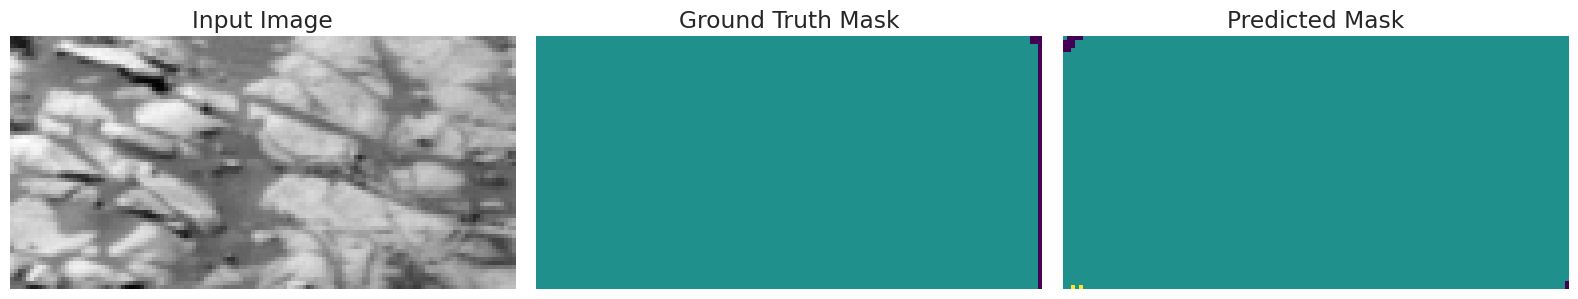

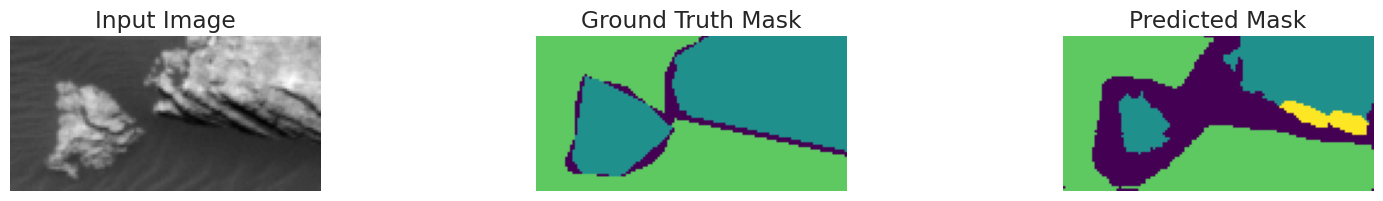

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.7072 - loss: 0.4696 - mean_iou: 0.4599 - val_accuracy: 0.6977 - val_loss: 0.5376 - val_mean_iou: 0.4393 - learning_rate: 1.0000e-04
SCCE weight: 0.4387, Dice weight: 0.2452, Boundary weight: 0.3161
Epoch 37/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7047 - loss: 0.4700 - mean_iou: 0.4504 - val_accuracy: 0.7163 - val_loss: 0.5046 - val_mean_iou: 0.4516 - learning_rate: 1.0000e-04
SCCE weight: 0.4396, Dice weight: 0.2417, Boundary weight: 0.3187
Epoch 38/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7168 - loss: 0.4549 - mean_iou: 0.4632 - val_accuracy: 0.7180 - val_loss: 0.5067 - val_mean_iou: 0.4557 - learning_rate: 1.0000e-04
SCCE weight: 0.4404, Dice weight: 0.2383, Boundary weight: 0.3213
Epoch 39/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7212 - loss: 0.4500 - mean_iou: 0.4666 - val_accuracy: 0.7167 - val_loss: 0.5095 - val_mean_iou: 0.4555 - learning_rate: 1.0000e-04
SCCE weight: 0.

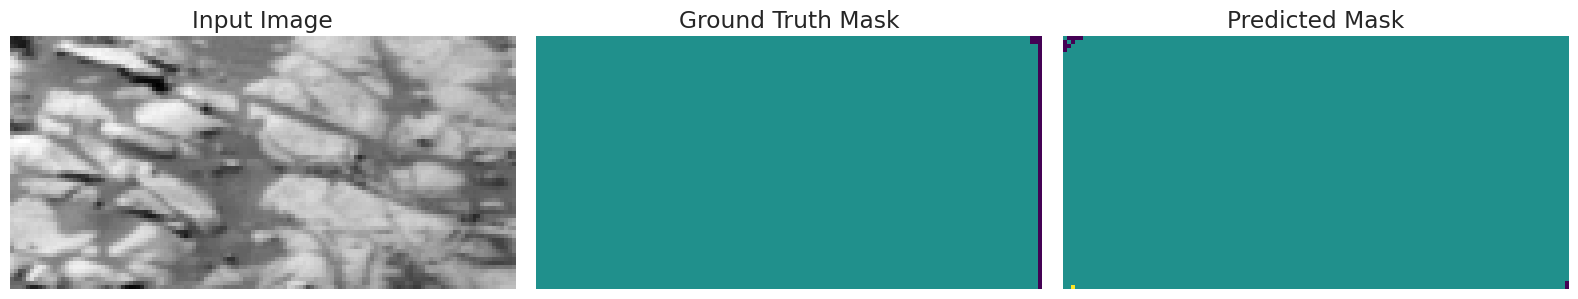

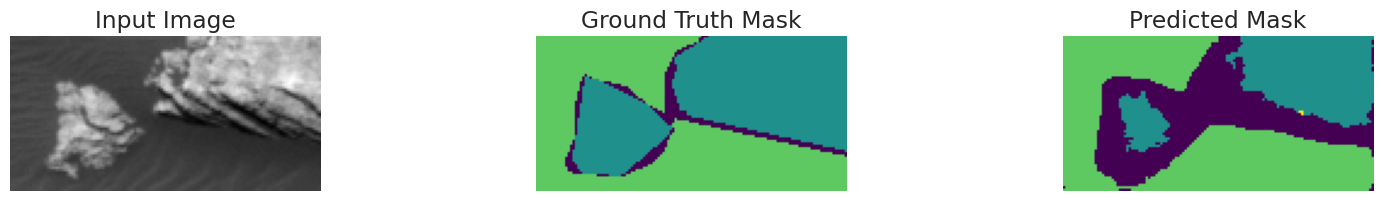

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.7170 - loss: 0.4525 - mean_iou: 0.4669 - val_accuracy: 0.7224 - val_loss: 0.5448 - val_mean_iou: 0.4543 - learning_rate: 1.0000e-04
SCCE weight: 0.4429, Dice weight: 0.2283, Boundary weight: 0.3288
Epoch 42/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7294 - loss: 0.4321 - mean_iou: 0.4698 - val_accuracy: 0.7149 - val_loss: 0.5247 - val_mean_iou: 0.4513 - learning_rate: 1.0000e-04
SCCE weight: 0.4437, Dice weight: 0.2250, Boundary weight: 0.3312
Epoch 43/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7271 - loss: 0.4350 - mean_iou: 0.4726 - val_accuracy: 0.7147 - val_loss: 0.4873 - val_mean_iou: 0.4504 - learning_rate: 1.0000e-04
SCCE weight: 0.4446, Dice weight: 0.2218, Boundary weight: 0.3337
Epoch 44/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7200 - loss: 0.4447 - mean_iou: 0.4618 - val_accuracy: 0.7202 - val_loss: 0.5097 - val_mean_iou: 0.4531 - learning_rate: 1.0000e-04
SCCE weight: 0.

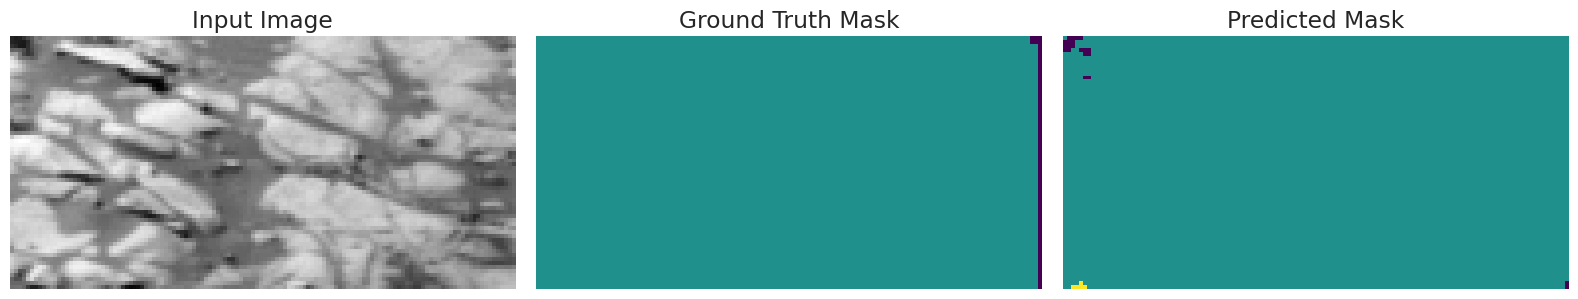

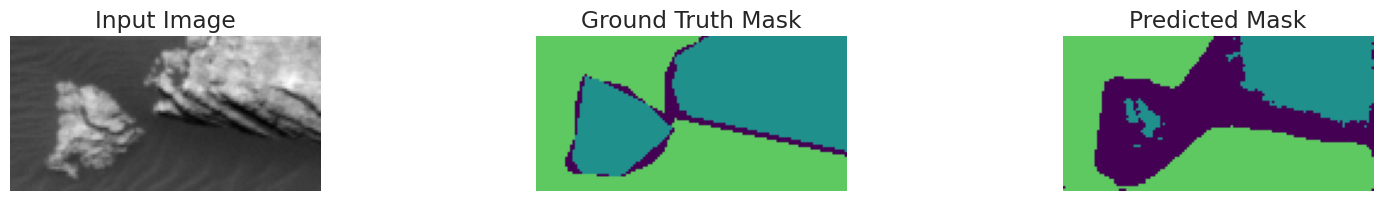

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.7367 - loss: 0.4160 - mean_iou: 0.4818 - val_accuracy: 0.7248 - val_loss: 0.5548 - val_mean_iou: 0.4507 - learning_rate: 1.0000e-04
SCCE weight: 0.4469, Dice weight: 0.2122, Boundary weight: 0.3408
Epoch 47/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7273 - loss: 0.4341 - mean_iou: 0.4740 - val_accuracy: 0.7161 - val_loss: 0.4869 - val_mean_iou: 0.4721 - learning_rate: 1.0000e-04
SCCE weight: 0.4477, Dice weight: 0.2091, Boundary weight: 0.3431
Epoch 48/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7350 - loss: 0.4215 - mean_iou: 0.4776 - val_accuracy: 0.7262 - val_loss: 0.5386 - val_mean_iou: 0.4629 - learning_rate: 1.0000e-04
SCCE weight: 0.4485, Dice weight: 0.2061, Boundary weight: 0.3455
Epoch 49/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7480 - loss: 0.4005 - mean_iou: 0.4991 - val_accuracy: 0.7355 - val_loss: 0.4791 - val_mean_iou: 0.4727 - learning_rate: 1.0000e-04
SCCE weight: 0.

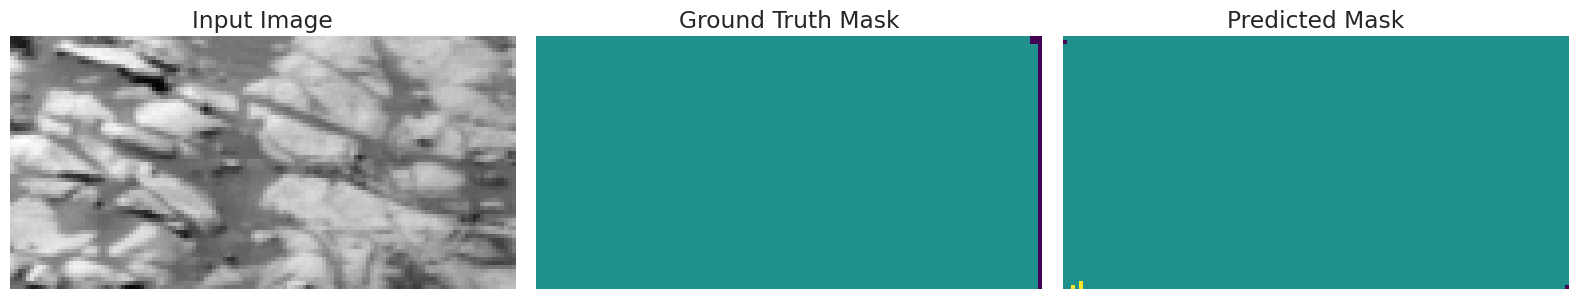

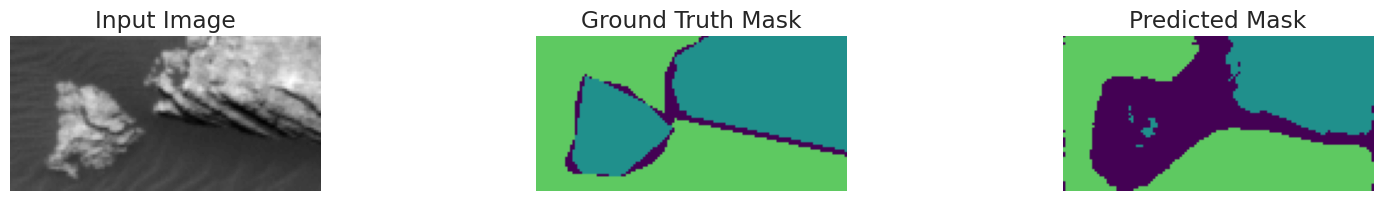

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.7467 - loss: 0.4000 - mean_iou: 0.4935 - val_accuracy: 0.7301 - val_loss: 0.5084 - val_mean_iou: 0.4707 - learning_rate: 1.0000e-04
SCCE weight: 0.4507, Dice weight: 0.1970, Boundary weight: 0.3522
Epoch 52/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7353 - loss: 0.4121 - mean_iou: 0.4891 - val_accuracy: 0.7302 - val_loss: 0.4940 - val_mean_iou: 0.4714 - learning_rate: 1.0000e-04
SCCE weight: 0.4515, Dice weight: 0.1941, Boundary weight: 0.3545
Epoch 53/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7069 - loss: 0.4624 - mean_iou: 0.4526 - val_accuracy: 0.7063 - val_loss: 0.4844 - val_mean_iou: 0.4233 - learning_rate: 1.0000e-04
SCCE weight: 0.4522, Dice weight: 0.1911, Boundary weight: 0.3567
Epoch 54/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7337 - loss: 0.4209 - mean_iou: 0.4755 - val_accuracy: 0.7205 - val_loss: 0.4641 - val_mean_iou: 0.4504 - learning_rate: 1.0000e-04
SCCE weight: 0.

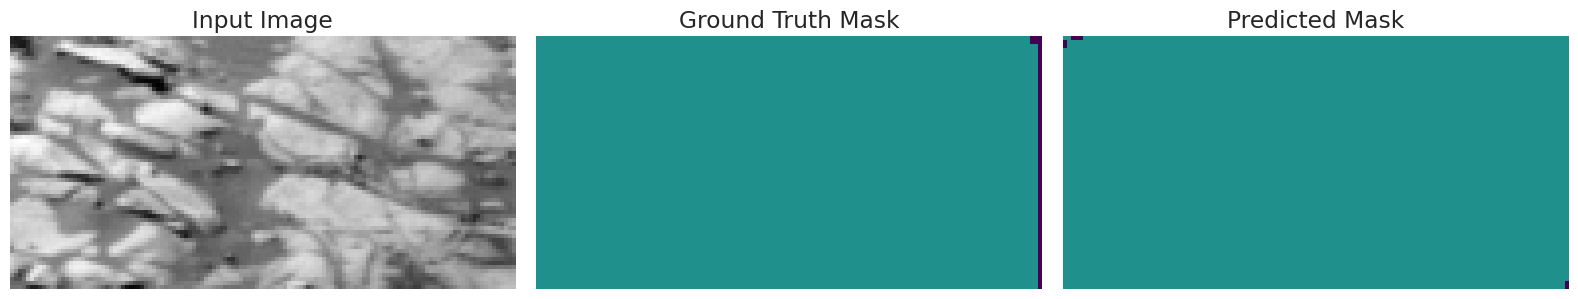

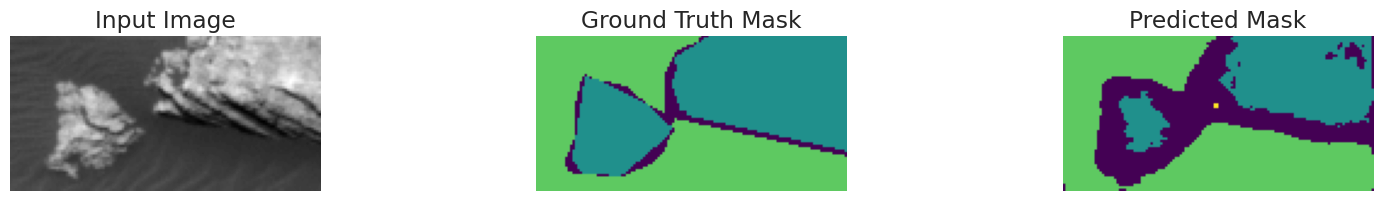

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - accuracy: 0.7560 - loss: 0.3860 - mean_iou: 0.5121 - val_accuracy: 0.7389 - val_loss: 0.4925 - val_mean_iou: 0.4720 - learning_rate: 1.0000e-04
SCCE weight: 0.4544, Dice weight: 0.1825, Boundary weight: 0.3631
Epoch 57/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.7597 - loss: 0.3791 - mean_iou: 0.5179 - val_accuracy: 0.7364 - val_loss: 0.4693 - val_mean_iou: 0.4795 - learning_rate: 1.0000e-04
SCCE weight: 0.4551, Dice weight: 0.1797, Boundary weight: 0.3652
Epoch 58/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7572 - loss: 0.3825 - mean_iou: 0.5143 - val_accuracy: 0.7346 - val_loss: 0.5554 - val_mean_iou: 0.4698 - learning_rate: 1.0000e-04
SCCE weight: 0.4558, Dice weight: 0.1769, Boundary weight: 0.3673
Epoch 59/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7618 - loss: 0.3757 - mean_iou: 0.5310 - val_accuracy: 0.7203 - val_loss: 0.5149 - val_mean_iou: 0.4494 - learning_rate: 1.0000e-04
SCCE weight: 0.

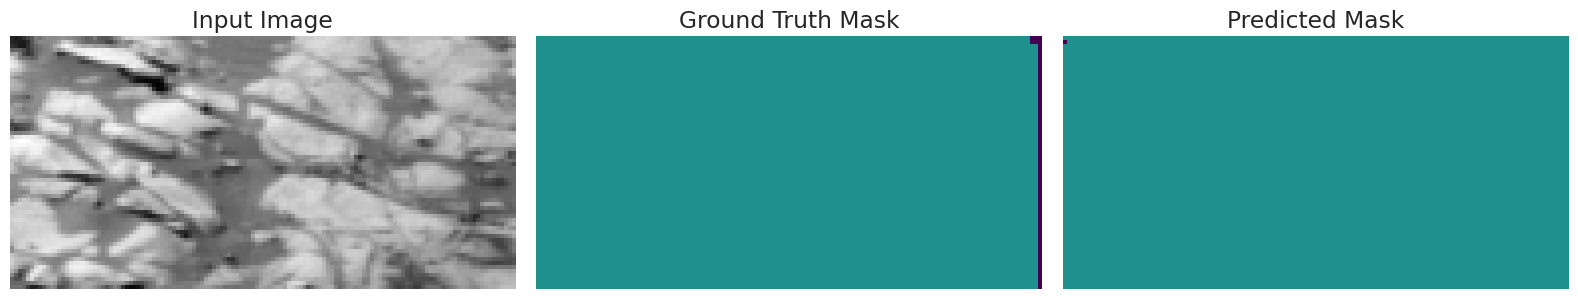

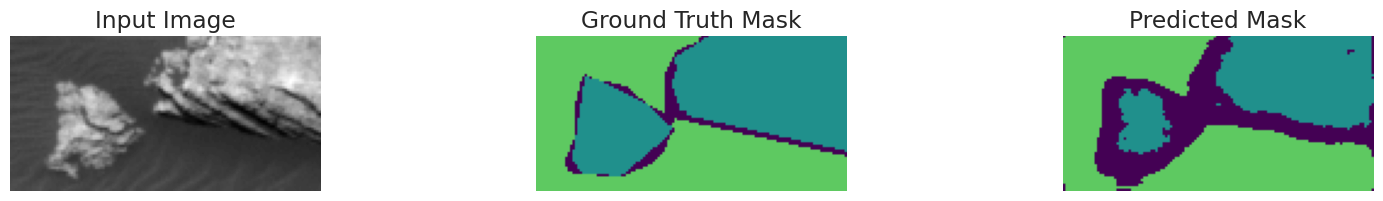

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.7560 - loss: 0.3860 - mean_iou: 0.5251 - val_accuracy: 0.7513 - val_loss: 0.5123 - val_mean_iou: 0.4892 - learning_rate: 1.0000e-04
SCCE weight: 0.4578, Dice weight: 0.1687, Boundary weight: 0.3735
Epoch 62/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7602 - loss: 0.3747 - mean_iou: 0.5210 - val_accuracy: 0.7403 - val_loss: 0.5064 - val_mean_iou: 0.4669 - learning_rate: 1.0000e-04
SCCE weight: 0.4585, Dice weight: 0.1660, Boundary weight: 0.3755
Epoch 63/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7623 - loss: 0.3747 - mean_iou: 0.5288 - val_accuracy: 0.7358 - val_loss: 0.4775 - val_mean_iou: 0.4659 - learning_rate: 1.0000e-04
SCCE weight: 0.4592, Dice weight: 0.1634, Boundary weight: 0.3775
Epoch 64/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7664 - loss: 0.3644 - mean_iou: 0.5324 - val_accuracy: 0.7449 - val_loss: 0.4916 - val_mean_iou: 0.4765 - learning_rate: 1.0000e-04
SCCE weight: 0.

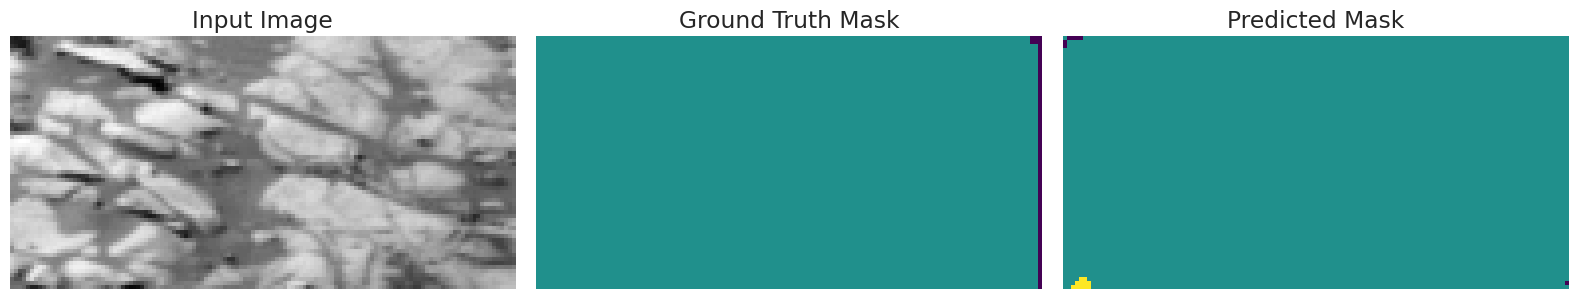

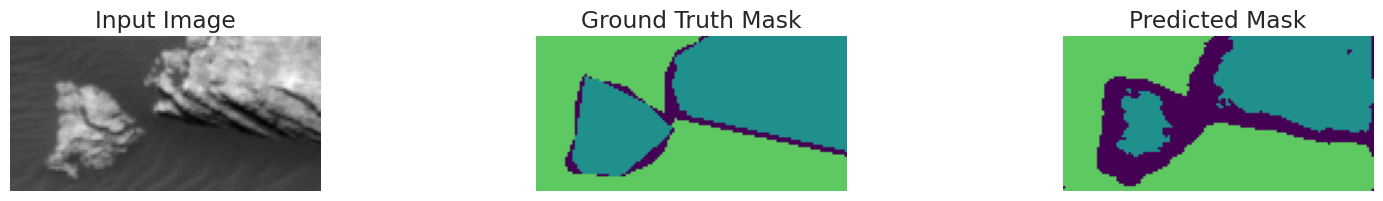

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.7682 - loss: 0.3624 - mean_iou: 0.5471 - val_accuracy: 0.7480 - val_loss: 0.4923 - val_mean_iou: 0.4758 - learning_rate: 1.0000e-04
SCCE weight: 0.4611, Dice weight: 0.1556, Boundary weight: 0.3833
Epoch 67/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7625 - loss: 0.3673 - mean_iou: 0.5378 - val_accuracy: 0.7150 - val_loss: 0.5583 - val_mean_iou: 0.4496 - learning_rate: 1.0000e-04
SCCE weight: 0.4618, Dice weight: 0.1530, Boundary weight: 0.3853
Epoch 68/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7664 - loss: 0.3664 - mean_iou: 0.5261 - val_accuracy: 0.7456 - val_loss: 0.4351 - val_mean_iou: 0.4859 - learning_rate: 1.0000e-04
SCCE weight: 0.4624, Dice weight: 0.1505, Boundary weight: 0.3872
Epoch 69/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.7640 - loss: 0.3682 - mean_iou: 0.5291 - val_accuracy: 0.7578 - val_loss: 0.4527 - val_mean_iou: 0.5138 - learning_rate: 1.0000e-04
SCCE weight: 0.

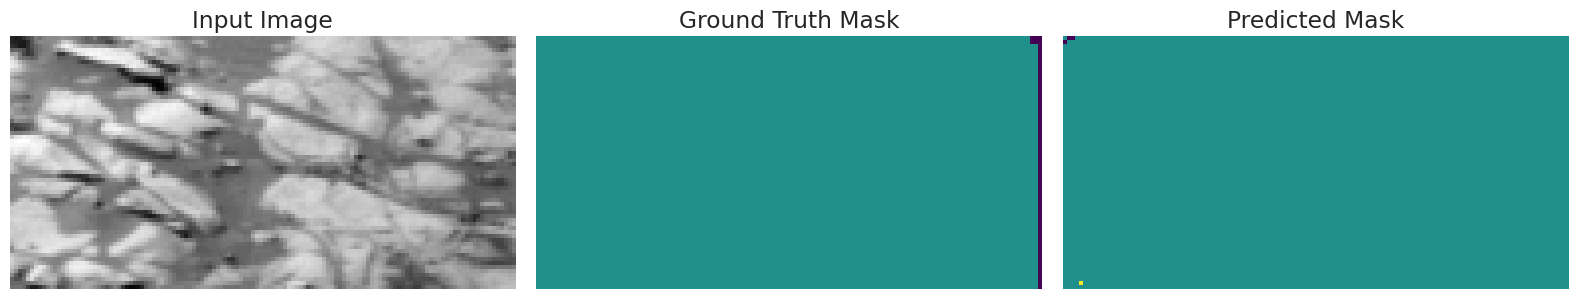

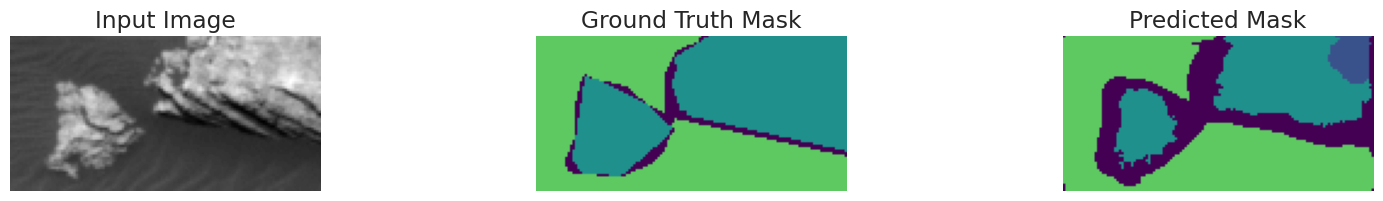

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.7700 - loss: 0.3566 - mean_iou: 0.5601 - val_accuracy: 0.7530 - val_loss: 0.4892 - val_mean_iou: 0.5007 - learning_rate: 1.0000e-04
SCCE weight: 0.4643, Dice weight: 0.1430, Boundary weight: 0.3928
Epoch 72/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7714 - loss: 0.3523 - mean_iou: 0.5707 - val_accuracy: 0.7368 - val_loss: 0.5898 - val_mean_iou: 0.4580 - learning_rate: 1.0000e-04
SCCE weight: 0.4649, Dice weight: 0.1405, Boundary weight: 0.3946
Epoch 73/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7763 - loss: 0.3462 - mean_iou: 0.5856 - val_accuracy: 0.7510 - val_loss: 0.4962 - val_mean_iou: 0.5051 - learning_rate: 1.0000e-04
SCCE weight: 0.4655, Dice weight: 0.1381, Boundary weight: 0.3964
Epoch 74/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.7775 - loss: 0.3459 - mean_iou: 0.5846 - val_accuracy: 0.7234 - val_loss: 0.6300 - val_mean_iou: 0.4386 - learning_rate: 1.0000e-04
SCCE weight: 0.

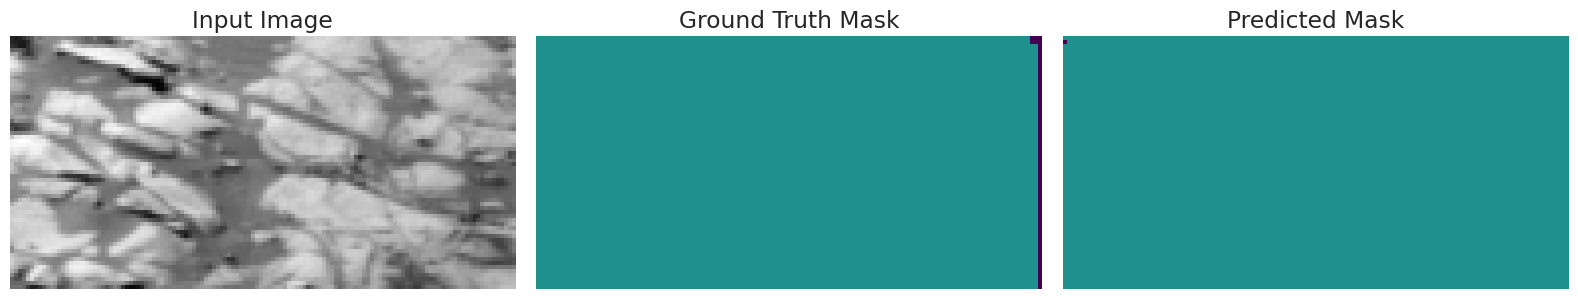

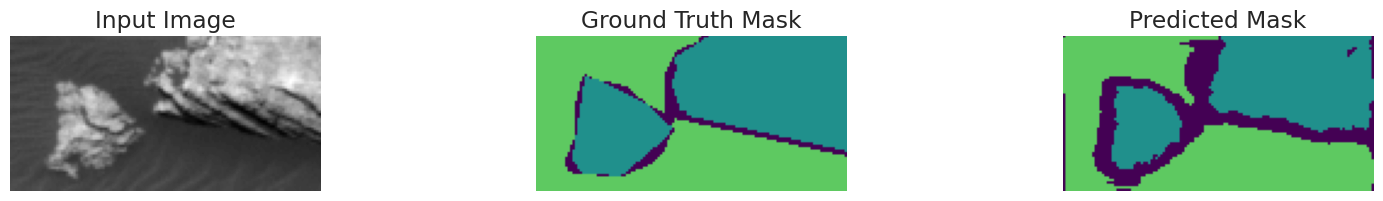

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.7754 - loss: 0.3492 - mean_iou: 0.5622 - val_accuracy: 0.7571 - val_loss: 0.5380 - val_mean_iou: 0.4990 - learning_rate: 1.0000e-04
SCCE weight: 0.4673, Dice weight: 0.1310, Boundary weight: 0.4018
Epoch 77/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7812 - loss: 0.3413 - mean_iou: 0.5976 - val_accuracy: 0.7535 - val_loss: 0.4941 - val_mean_iou: 0.4835 - learning_rate: 1.0000e-04
SCCE weight: 0.4678, Dice weight: 0.1286, Boundary weight: 0.4035
Epoch 78/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7818 - loss: 0.3432 - mean_iou: 0.5609 - val_accuracy: 0.7531 - val_loss: 0.4730 - val_mean_iou: 0.4898 - learning_rate: 1.0000e-04
SCCE weight: 0.4684, Dice weight: 0.1263, Boundary weight: 0.4053
Epoch 79/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7831 - loss: 0.3416 - mean_iou: 0.5928 - val_accuracy: 0.7555 - val_loss: 0.5323 - val_mean_iou: 0.5114 - learning_rate: 1.0000e-04
SCCE weight: 0.

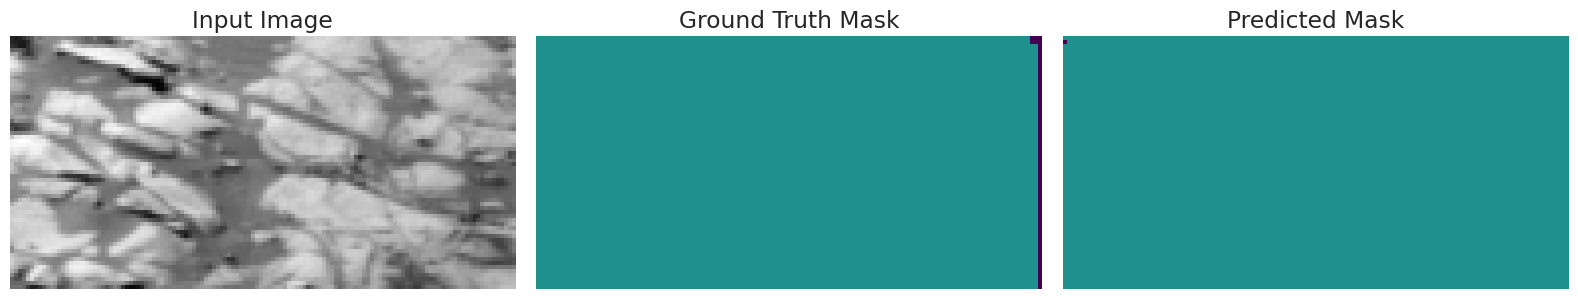

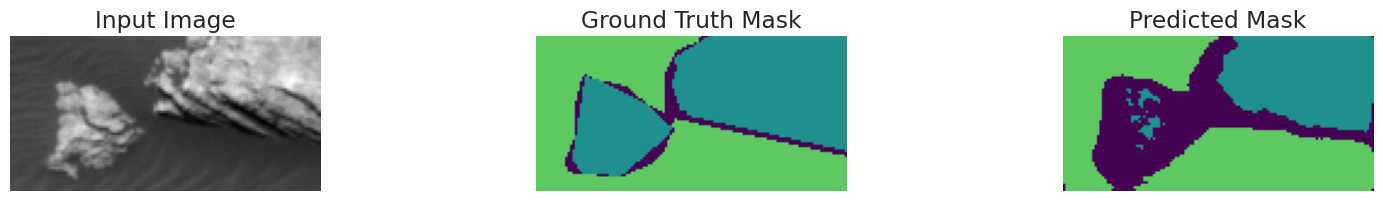

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.7807 - loss: 0.3435 - mean_iou: 0.5750 - val_accuracy: 0.7434 - val_loss: 0.4546 - val_mean_iou: 0.4867 - learning_rate: 1.0000e-04
SCCE weight: 0.4701, Dice weight: 0.1195, Boundary weight: 0.4104
Epoch 82/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7798 - loss: 0.3422 - mean_iou: 0.5970 - val_accuracy: 0.7399 - val_loss: 0.5254 - val_mean_iou: 0.4895 - learning_rate: 1.0000e-04
SCCE weight: 0.4707, Dice weight: 0.1172, Boundary weight: 0.4121
Epoch 83/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7878 - loss: 0.3304 - mean_iou: 0.5899 - val_accuracy: 0.7315 - val_loss: 0.4972 - val_mean_iou: 0.4768 - learning_rate: 1.0000e-04
SCCE weight: 0.4712, Dice weight: 0.1150, Boundary weight: 0.4137
Epoch 84/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7980 - loss: 0.3177 - mean_iou: 0.6238 - val_accuracy: 0.7578 - val_loss: 0.4858 - val_mean_iou: 0.5079 - learning_rate: 1.0000e-04
SCCE weight: 0.

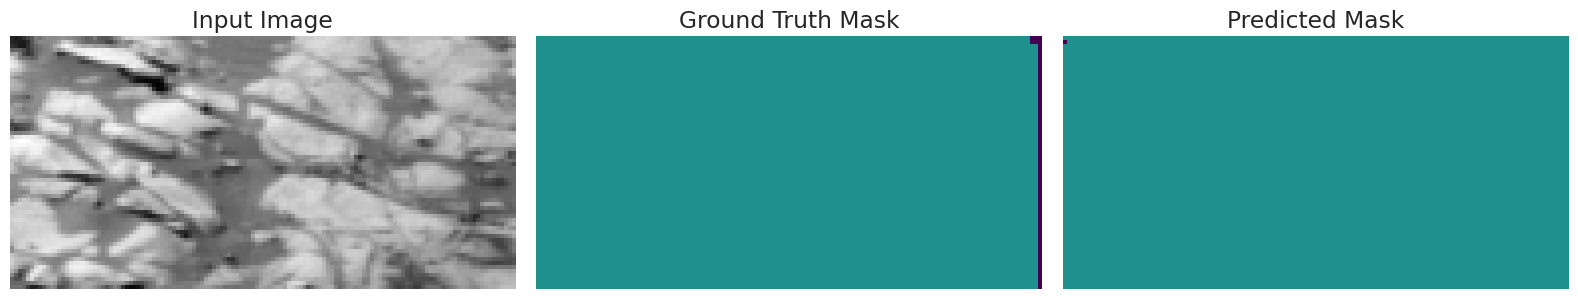

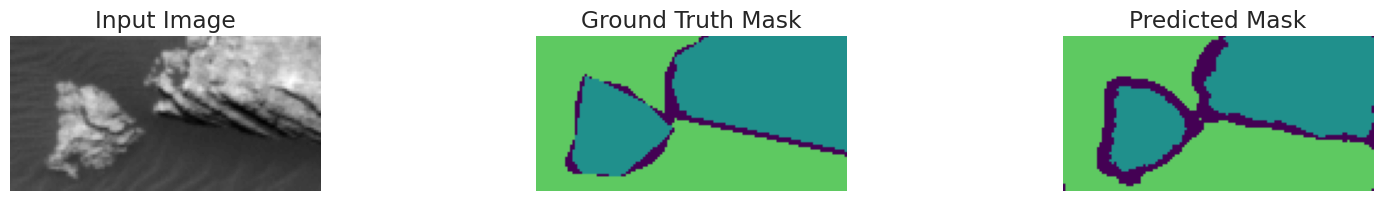

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7988 - loss: 0.3140 - mean_iou: 0.6115 - val_accuracy: 0.7631 - val_loss: 0.4781 - val_mean_iou: 0.5161 - learning_rate: 1.0000e-05
SCCE weight: 0.4729, Dice weight: 0.1085, Boundary weight: 0.4186
Epoch 87/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.7990 - loss: 0.3152 - mean_iou: 0.6167 - val_accuracy: 0.7629 - val_loss: 0.4773 - val_mean_iou: 0.5170 - learning_rate: 1.0000e-05
SCCE weight: 0.4734, Dice weight: 0.1063, Boundary weight: 0.4203
Epoch 88/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.8021 - loss: 0.3075 - mean_iou: 0.6308 - val_accuracy: 0.7647 - val_loss: 0.4796 - val_mean_iou: 0.5211 - learning_rate: 1.0000e-05
SCCE weight: 0.4739, Dice weight: 0.1042, Boundary weight: 0.4218
Epoch 89/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.8031 - loss: 0.3085 - mean_iou: 0.6350 - val_accuracy: 0.7638 - val_loss: 0.4829 - val_mean_iou: 0.5217 - learning_rate: 1.0000e-05
SCCE weight: 0.

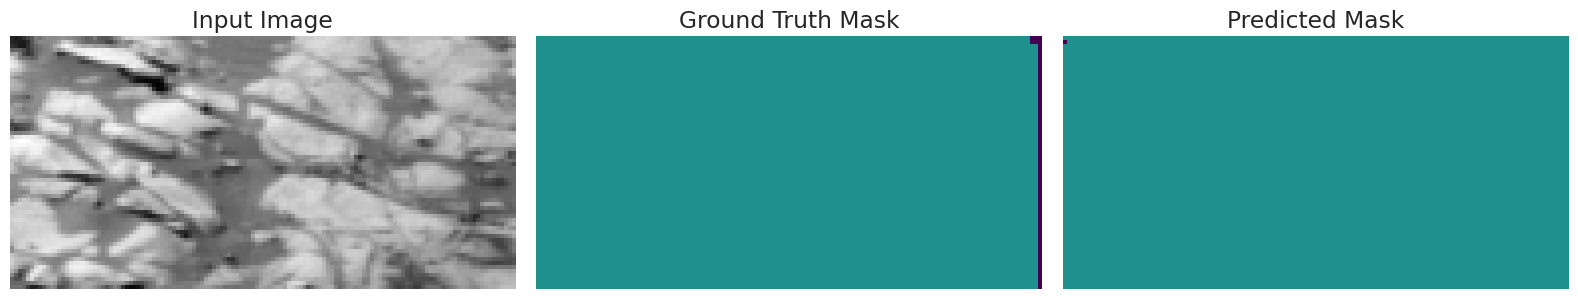

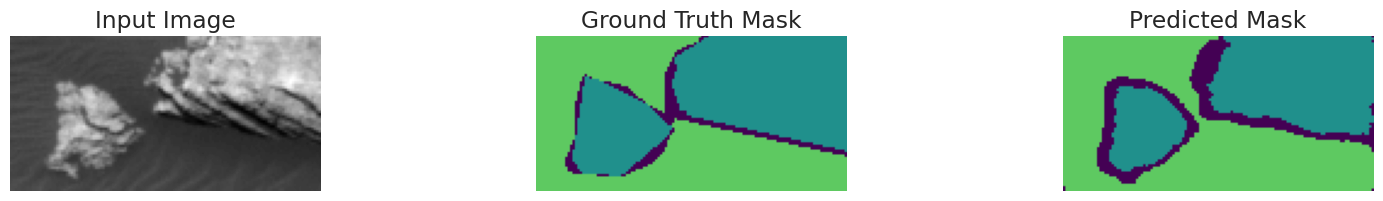

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8052 - loss: 0.3108 - mean_iou: 0.6244 - val_accuracy: 0.7618 - val_loss: 0.4627 - val_mean_iou: 0.5120 - learning_rate: 1.0000e-05
SCCE weight: 0.4755, Dice weight: 0.0979, Boundary weight: 0.4266
Epoch 92/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7993 - loss: 0.3180 - mean_iou: 0.6154 - val_accuracy: 0.7631 - val_loss: 0.4668 - val_mean_iou: 0.5178 - learning_rate: 1.0000e-05
SCCE weight: 0.4760, Dice weight: 0.0959, Boundary weight: 0.4281
Epoch 93/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.7975 - loss: 0.3189 - mean_iou: 0.6190 - val_accuracy: 0.7625 - val_loss: 0.4833 - val_mean_iou: 0.5176 - learning_rate: 1.0000e-05
SCCE weight: 0.4765, Dice weight: 0.0938, Boundary weight: 0.4296
Epoch 94/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.8057 - loss: 0.3089 - mean_iou: 0.6522 - val_accuracy: 0.7663 - val_loss: 0.4797 - val_mean_iou: 0.5217 - learning_rate: 1.0000e-05
SCCE weight: 0.

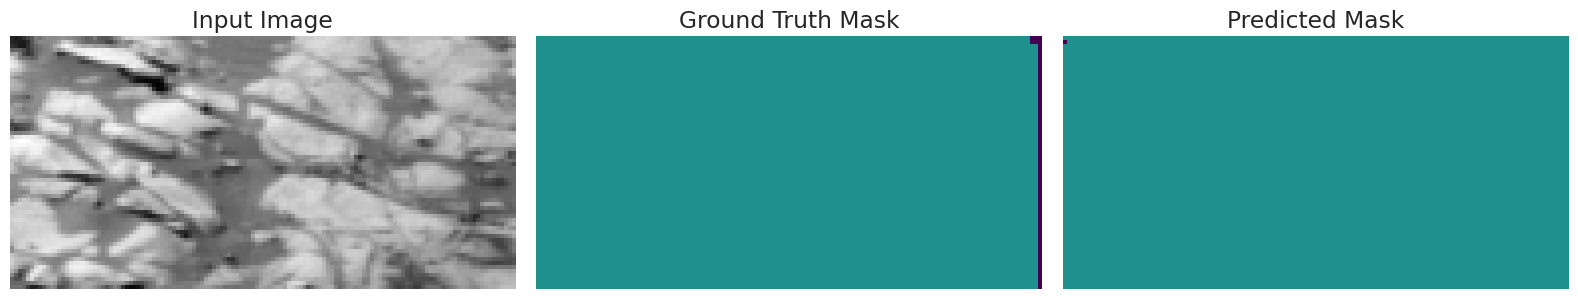

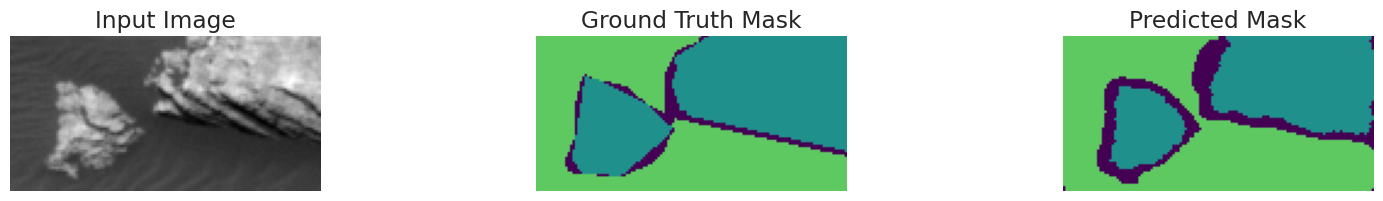

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.8050 - loss: 0.3053 - mean_iou: 0.6286 - val_accuracy: 0.7629 - val_loss: 0.4797 - val_mean_iou: 0.5151 - learning_rate: 1.0000e-05
SCCE weight: 0.4780, Dice weight: 0.0878, Boundary weight: 0.4341
Epoch 97/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8074 - loss: 0.3047 - mean_iou: 0.6372 - val_accuracy: 0.7634 - val_loss: 0.4855 - val_mean_iou: 0.5164 - learning_rate: 1.0000e-05
SCCE weight: 0.4785, Dice weight: 0.0858, Boundary weight: 0.4356
Epoch 98/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8102 - loss: 0.3034 - mean_iou: 0.6558 - val_accuracy: 0.7646 - val_loss: 0.4753 - val_mean_iou: 0.5189 - learning_rate: 1.0000e-05
SCCE weight: 0.4790, Dice weight: 0.0839, Boundary weight: 0.4371
Epoch 99/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8086 - loss: 0.3033 - mean_iou: 0.6398 - val_accuracy: 0.7654 - val_loss: 0.4766 - val_mean_iou: 0.5199 - learning_rate: 1.0000e-05
SCCE weight: 0.

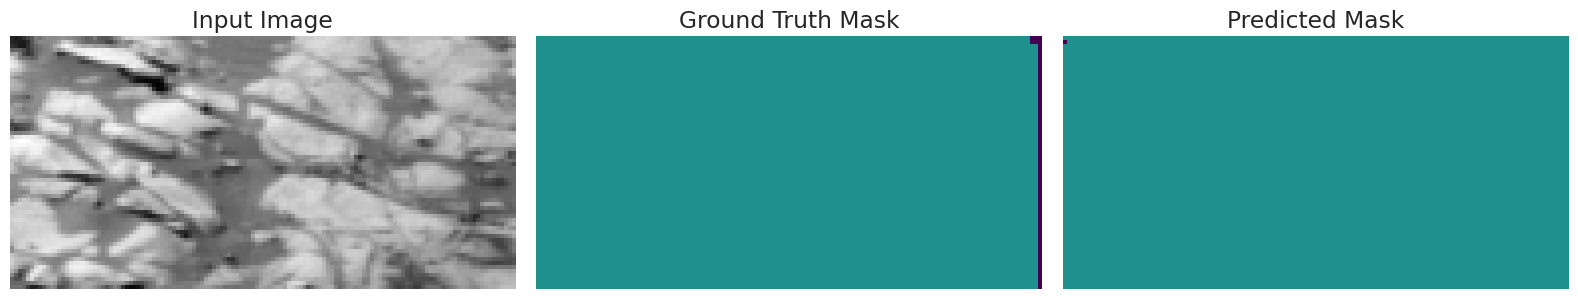

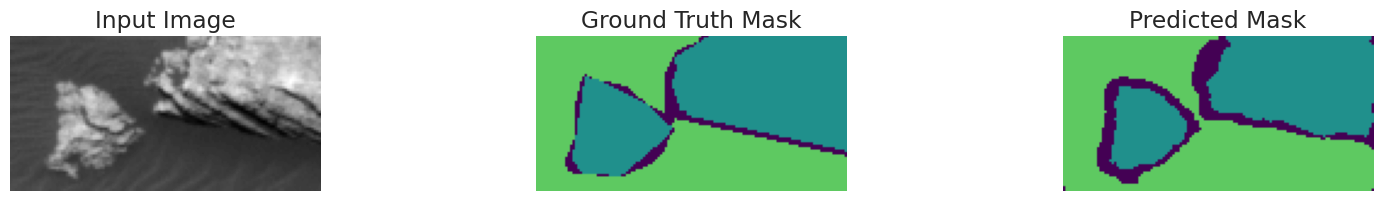

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.8051 - loss: 0.3058 - mean_iou: 0.6408 - val_accuracy: 0.7639 - val_loss: 0.4862 - val_mean_iou: 0.5162 - learning_rate: 1.0000e-05
SCCE weight: 0.4805, Dice weight: 0.0781, Boundary weight: 0.4414
Epoch 102/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8027 - loss: 0.3092 - mean_iou: 0.6466 - val_accuracy: 0.7623 - val_loss: 0.4850 - val_mean_iou: 0.5188 - learning_rate: 1.0000e-05
SCCE weight: 0.4810, Dice weight: 0.0762, Boundary weight: 0.4429
Epoch 103/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.8089 - loss: 0.3006 - mean_iou: 0.6223 - val_accuracy: 0.7645 - val_loss: 0.4682 - val_mean_iou: 0.5219 - learning_rate: 1.0000e-05
SCCE weight: 0.4814, Dice weight: 0.0743, Boundary weight: 0.4443
Epoch 104/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8060 - loss: 0.3046 - mean_iou: 0.6225 - val_accuracy: 0.7634 - val_loss: 0.4717 - val_mean_iou: 0.5197 - learning_rate: 1.0000e-05
SCCE weight:

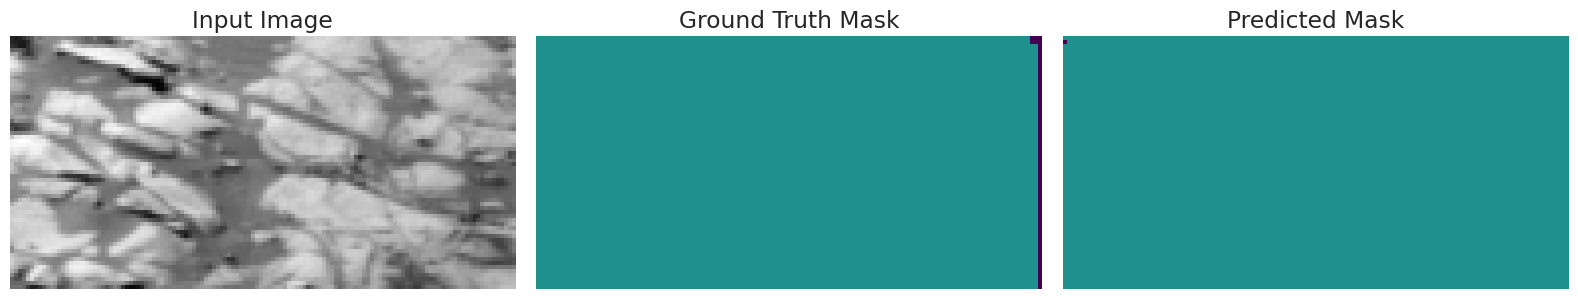

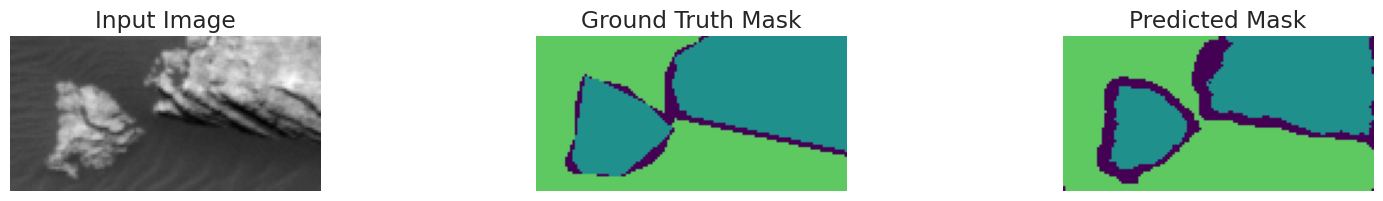

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.8114 - loss: 0.2991 - mean_iou: 0.6505 - val_accuracy: 0.7645 - val_loss: 0.4767 - val_mean_iou: 0.5210 - learning_rate: 1.0000e-05
SCCE weight: 0.4828, Dice weight: 0.0688, Boundary weight: 0.4484
Epoch 107/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8103 - loss: 0.3007 - mean_iou: 0.6419 - val_accuracy: 0.7640 - val_loss: 0.4751 - val_mean_iou: 0.5211 - learning_rate: 1.0000e-05
SCCE weight: 0.4833, Dice weight: 0.0669, Boundary weight: 0.4498
Epoch 108/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8059 - loss: 0.3073 - mean_iou: 0.6367 - val_accuracy: 0.7631 - val_loss: 0.4825 - val_mean_iou: 0.5199 - learning_rate: 1.0000e-05
SCCE weight: 0.4837, Dice weight: 0.0651, Boundary weight: 0.4512
Epoch 109/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8110 - loss: 0.2996 - mean_iou: 0.6312 - val_accuracy: 0.7628 - val_loss: 0.4809 - val_mean_iou: 0.5191 - learning_rate: 1.0000e-05
SCCE weight:

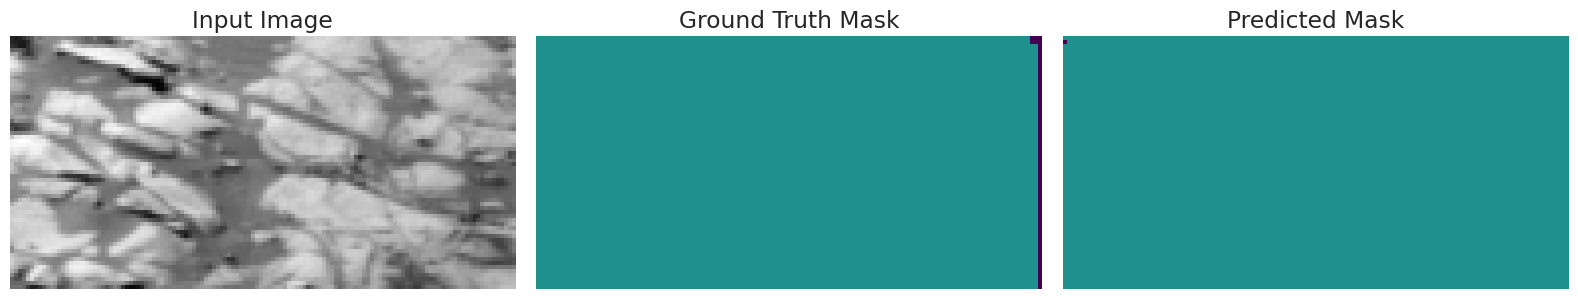

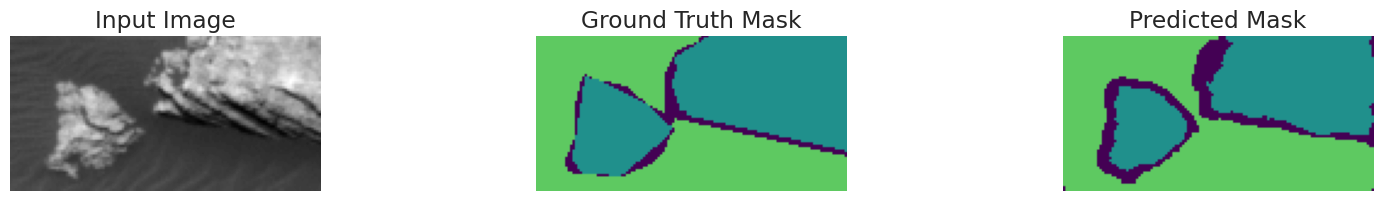

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.8112 - loss: 0.3016 - mean_iou: 0.6539 - val_accuracy: 0.7641 - val_loss: 0.4836 - val_mean_iou: 0.5236 - learning_rate: 1.0000e-05
SCCE weight: 0.4851, Dice weight: 0.0598, Boundary weight: 0.4552
Epoch 112/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8148 - loss: 0.2959 - mean_iou: 0.6490 - val_accuracy: 0.7640 - val_loss: 0.4802 - val_mean_iou: 0.5225 - learning_rate: 1.0000e-05
SCCE weight: 0.4855, Dice weight: 0.0580, Boundary weight: 0.4565
Epoch 113/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8057 - loss: 0.3069 - mean_iou: 0.6430 - val_accuracy: 0.7630 - val_loss: 0.4705 - val_mean_iou: 0.5172 - learning_rate: 1.0000e-05
SCCE weight: 0.4859, Dice weight: 0.0563, Boundary weight: 0.4578
Epoch 114/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8149 - loss: 0.2952 - mean_iou: 0.6450 - val_accuracy: 0.7635 - val_loss: 0.4775 - val_mean_iou: 0.5189 - learning_rate: 1.0000e-05
SCCE weight:

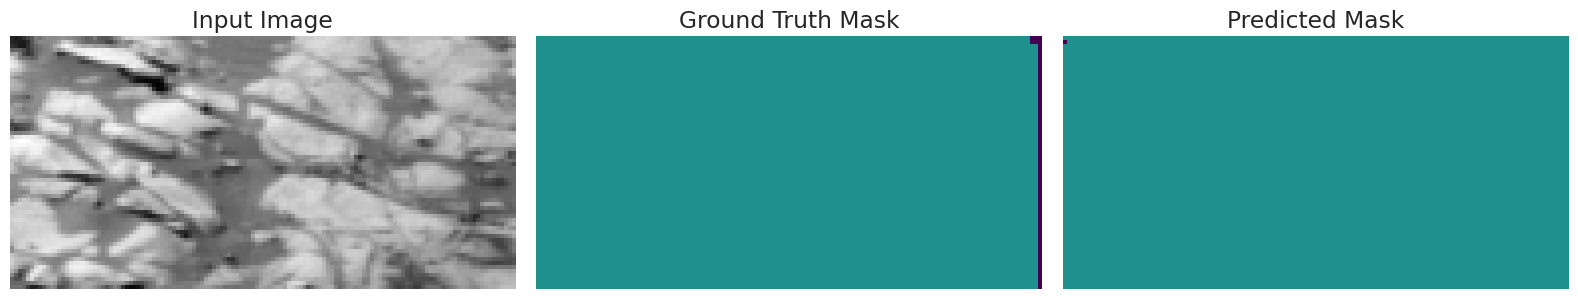

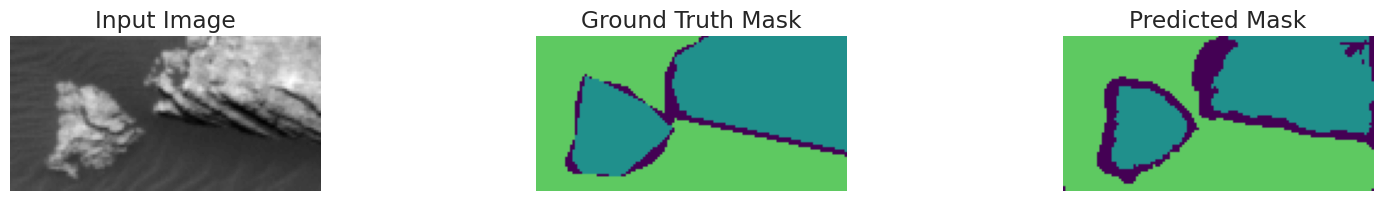

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.8154 - loss: 0.2952 - mean_iou: 0.6461 - val_accuracy: 0.7594 - val_loss: 0.4895 - val_mean_iou: 0.5158 - learning_rate: 1.0000e-05
SCCE weight: 0.4872, Dice weight: 0.0511, Boundary weight: 0.4617
Epoch 117/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8102 - loss: 0.2985 - mean_iou: 0.6485 - val_accuracy: 0.7614 - val_loss: 0.4825 - val_mean_iou: 0.5199 - learning_rate: 1.0000e-05
SCCE weight: 0.4876, Dice weight: 0.0494, Boundary weight: 0.4629
Epoch 118/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8093 - loss: 0.3031 - mean_iou: 0.6474 - val_accuracy: 0.7636 - val_loss: 0.4779 - val_mean_iou: 0.5193 - learning_rate: 1.0000e-05
SCCE weight: 0.4881, Dice weight: 0.0478, Boundary weight: 0.4642
Epoch 119/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8100 - loss: 0.3004 - mean_iou: 0.6469 - val_accuracy: 0.7646 - val_loss: 0.4779 - val_mean_iou: 0.5202 - learning_rate: 1.0000e-05
SCCE weight:

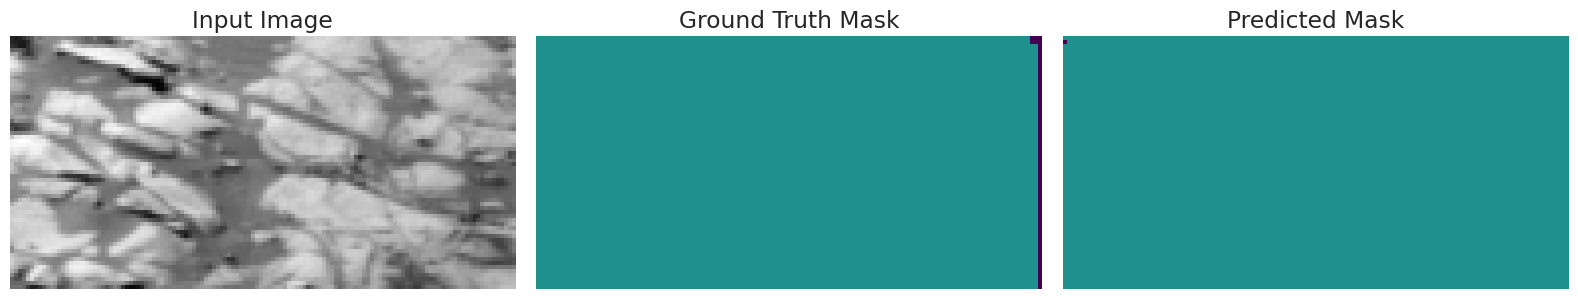

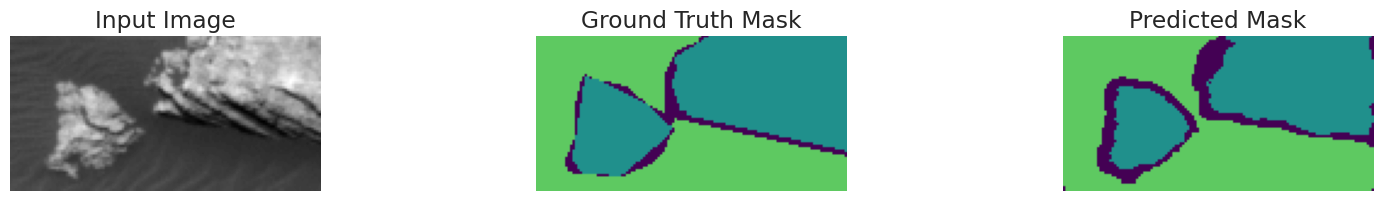

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.8132 - loss: 0.2967 - mean_iou: 0.6564 - val_accuracy: 0.7651 - val_loss: 0.4881 - val_mean_iou: 0.5232 - learning_rate: 1.0000e-05
SCCE weight: 0.4893, Dice weight: 0.0428, Boundary weight: 0.4679
Epoch 122/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8132 - loss: 0.2969 - mean_iou: 0.6523 - val_accuracy: 0.7640 - val_loss: 0.4914 - val_mean_iou: 0.5189 - learning_rate: 1.0000e-05
SCCE weight: 0.4897, Dice weight: 0.0412, Boundary weight: 0.4691
Epoch 123/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8167 - loss: 0.2944 - mean_iou: 0.6488 - val_accuracy: 0.7656 - val_loss: 0.4895 - val_mean_iou: 0.5192 - learning_rate: 1.0000e-05
SCCE weight: 0.4901, Dice weight: 0.0396, Boundary weight: 0.4703
Epoch 124/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8143 - loss: 0.2984 - mean_iou: 0.6487 - val_accuracy: 0.7651 - val_loss: 0.4934 - val_mean_iou: 0.5219 - learning_rate: 1.0000e-05
SCCE weight:

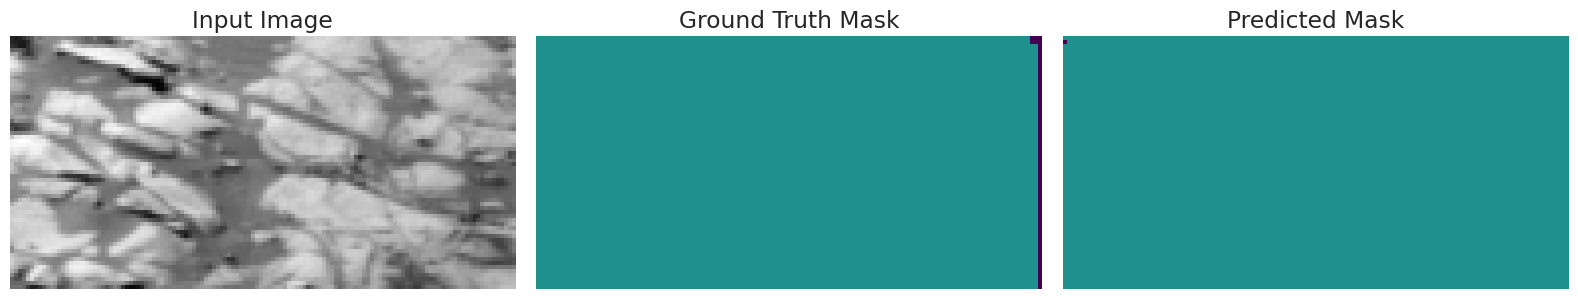

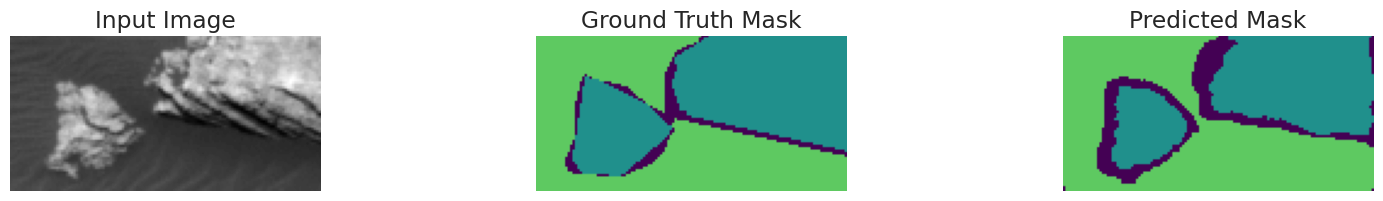

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 222ms/step - accuracy: 0.8176 - loss: 0.2893 - mean_iou: 0.6546 - val_accuracy: 0.7623 - val_loss: 0.4918 - val_mean_iou: 0.5154 - learning_rate: 1.0000e-06
SCCE weight: 0.4913, Dice weight: 0.0348, Boundary weight: 0.4739
Epoch 127/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8194 - loss: 0.2891 - mean_iou: 0.6550 - val_accuracy: 0.7622 - val_loss: 0.4891 - val_mean_iou: 0.5144 - learning_rate: 1.0000e-06
SCCE weight: 0.4917, Dice weight: 0.0332, Boundary weight: 0.4751
Epoch 128/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8171 - loss: 0.2916 - mean_iou: 0.6545 - val_accuracy: 0.7620 - val_loss: 0.4883 - val_mean_iou: 0.5135 - learning_rate: 1.0000e-06
SCCE weight: 0.4921, Dice weight: 0.0317, Boundary weight: 0.4763
Epoch 129/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8187 - loss: 0.2913 - mean_iou: 0.6490 - val_accuracy: 0.7625 - val_loss: 0.4881 - val_mean_iou: 0.5141 - learning_rate: 1.0000e-06
SCCE weight:

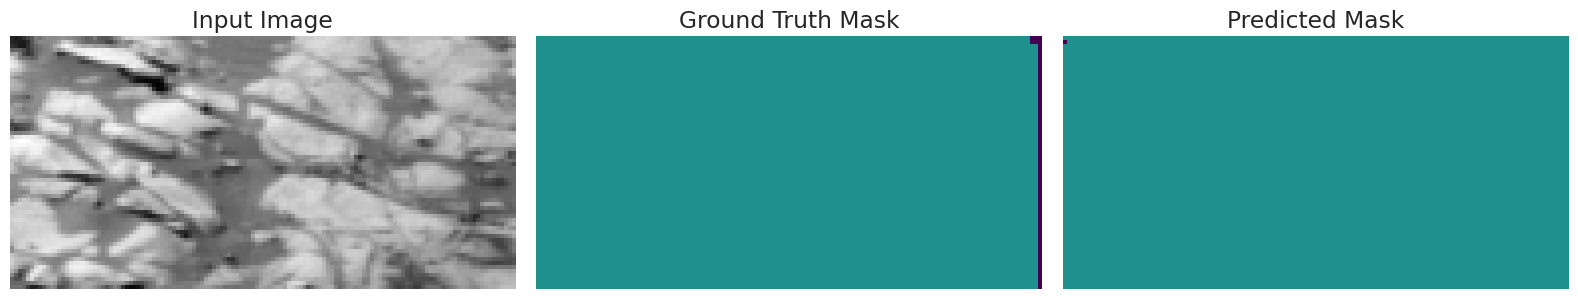

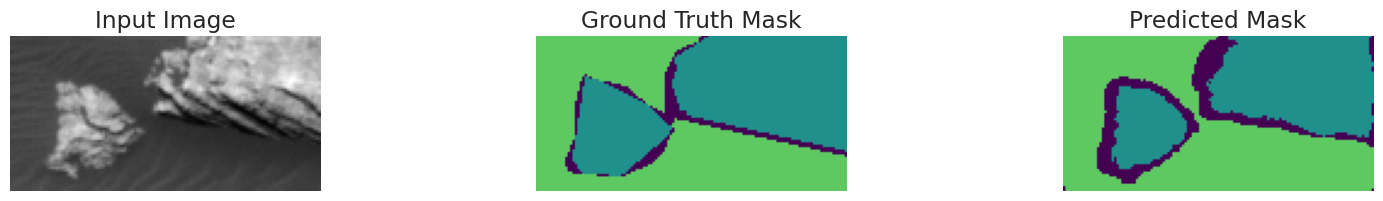

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.8133 - loss: 0.2957 - mean_iou: 0.6575 - val_accuracy: 0.7624 - val_loss: 0.4856 - val_mean_iou: 0.5133 - learning_rate: 1.0000e-06
SCCE weight: 0.4932, Dice weight: 0.0270, Boundary weight: 0.4797
Epoch 132/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8172 - loss: 0.2907 - mean_iou: 0.6523 - val_accuracy: 0.7626 - val_loss: 0.4862 - val_mean_iou: 0.5140 - learning_rate: 1.0000e-06
SCCE weight: 0.4936, Dice weight: 0.0255, Boundary weight: 0.4809
Epoch 133/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8123 - loss: 0.3008 - mean_iou: 0.6499 - val_accuracy: 0.7623 - val_loss: 0.4876 - val_mean_iou: 0.5135 - learning_rate: 1.0000e-06
SCCE weight: 0.4940, Dice weight: 0.0240, Boundary weight: 0.4820
Epoch 134/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8176 - loss: 0.2904 - mean_iou: 0.6576 - val_accuracy: 0.7622 - val_loss: 0.4874 - val_mean_iou: 0.5137 - learning_rate: 1.0000e-06
SCCE weight:

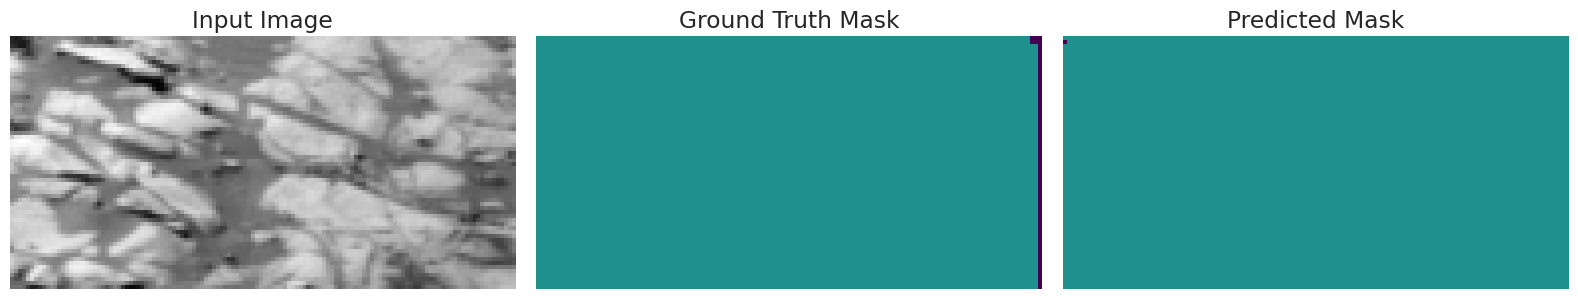

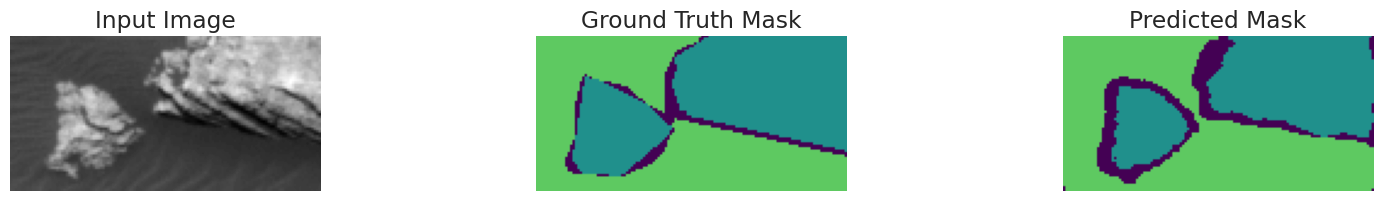

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 221ms/step - accuracy: 0.8141 - loss: 0.2947 - mean_iou: 0.6542 - val_accuracy: 0.7625 - val_loss: 0.4856 - val_mean_iou: 0.5144 - learning_rate: 1.0000e-06
SCCE weight: 0.4951, Dice weight: 0.0196, Boundary weight: 0.4853
Epoch 137/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8185 - loss: 0.2906 - mean_iou: 0.6599 - val_accuracy: 0.7626 - val_loss: 0.4841 - val_mean_iou: 0.5144 - learning_rate: 1.0000e-06
SCCE weight: 0.4955, Dice weight: 0.0181, Boundary weight: 0.4864
Epoch 138/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.8143 - loss: 0.2943 - mean_iou: 0.6458 - val_accuracy: 0.7631 - val_loss: 0.4843 - val_mean_iou: 0.5153 - learning_rate: 1.0000e-06
SCCE weight: 0.4958, Dice weight: 0.0167, Boundary weight: 0.4875
Epoch 139/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.8244 - loss: 0.2837 - mean_iou: 0.6496 - val_accuracy: 0.7633 - val_loss: 0.4840 - val_mean_iou: 0.5152 - learning_rate: 1.0000e-06
SCCE weight:

In [29]:
# Train the model
history = model.fit( 
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, learning_rate, epoch_tracker, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file 
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

del model

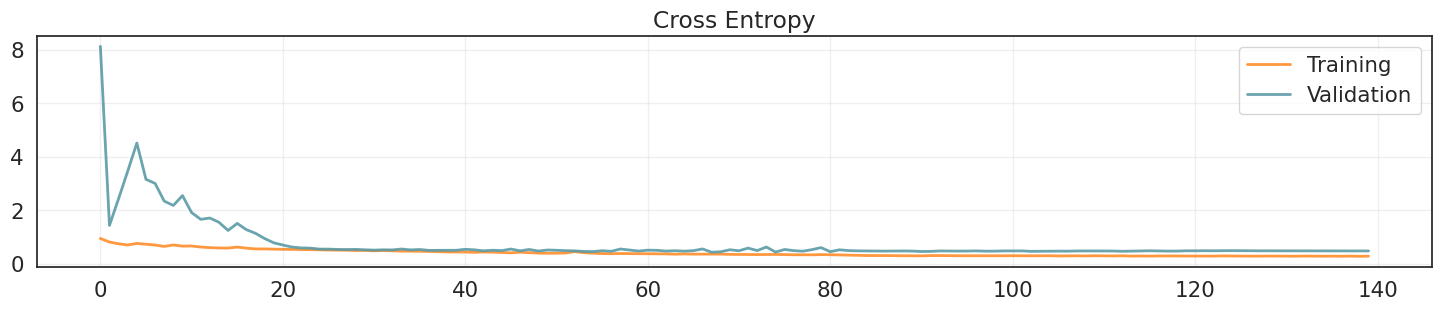

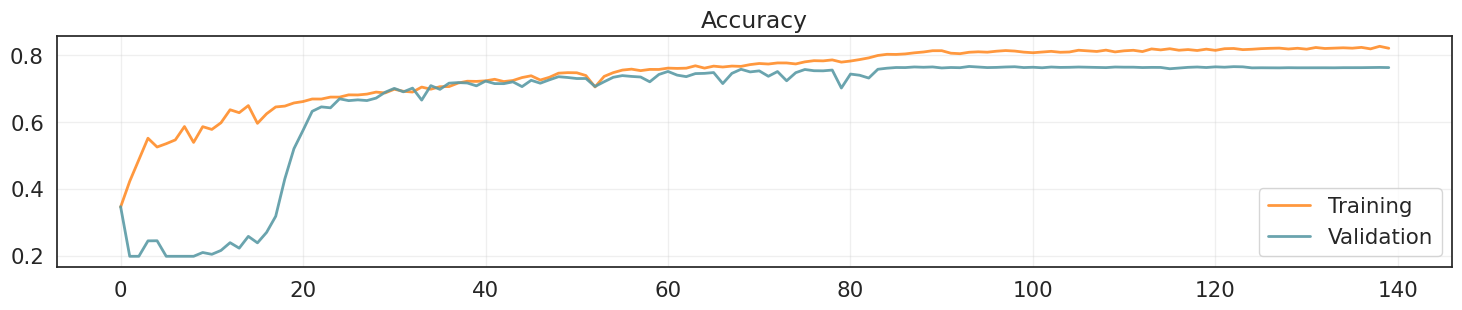

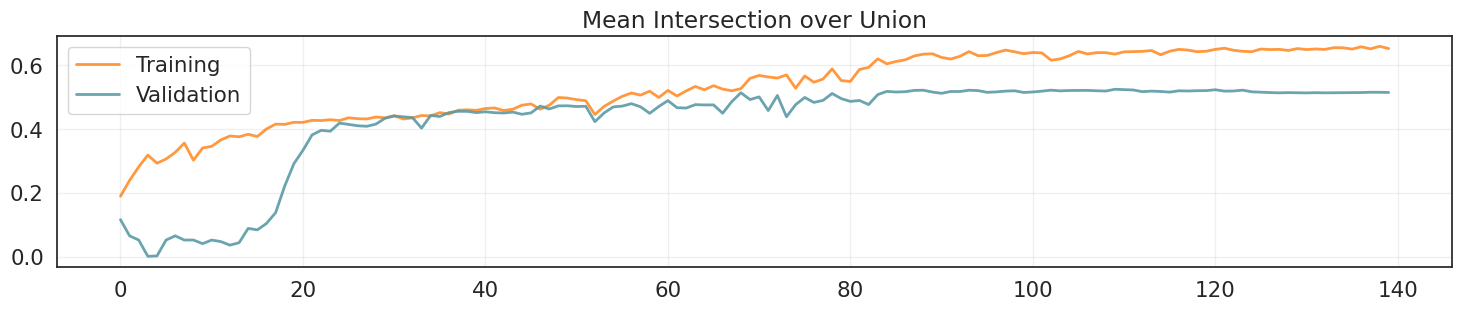

In [30]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔮 Predictions on the Test Set

In [31]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [32]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241205_122540.keras


In [33]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step
Predictions shape: (10022, 64, 128)


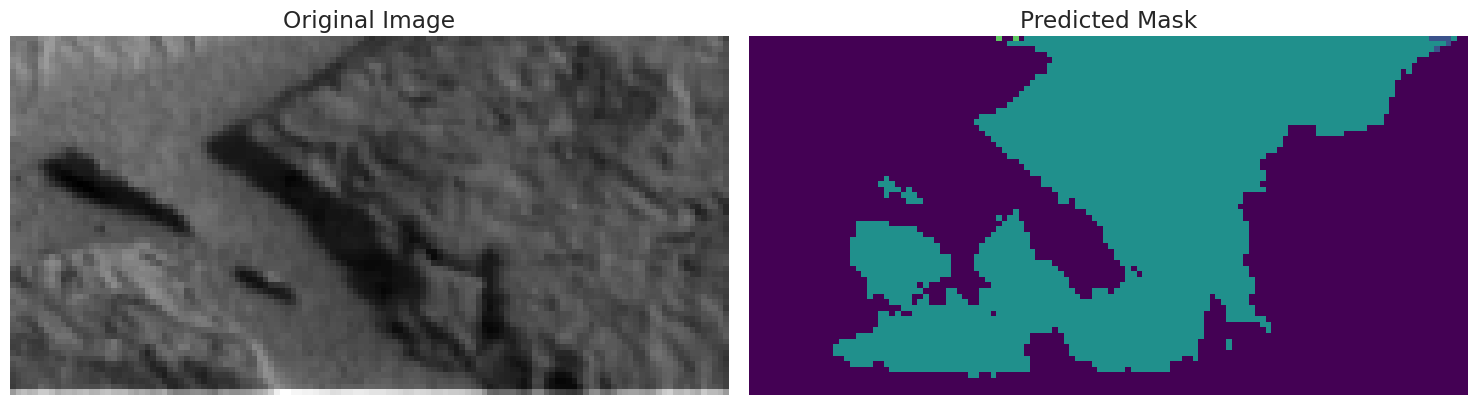

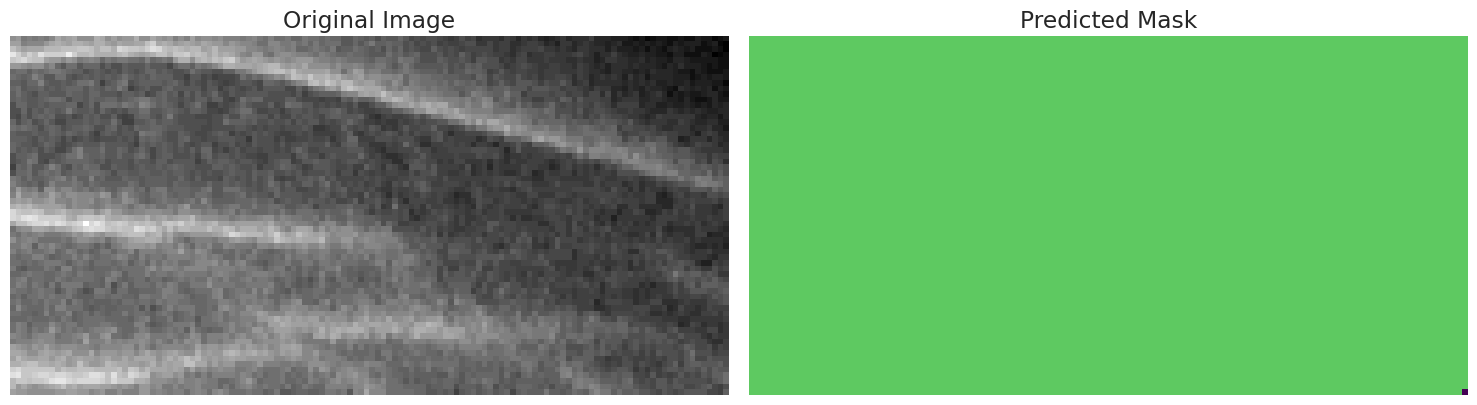

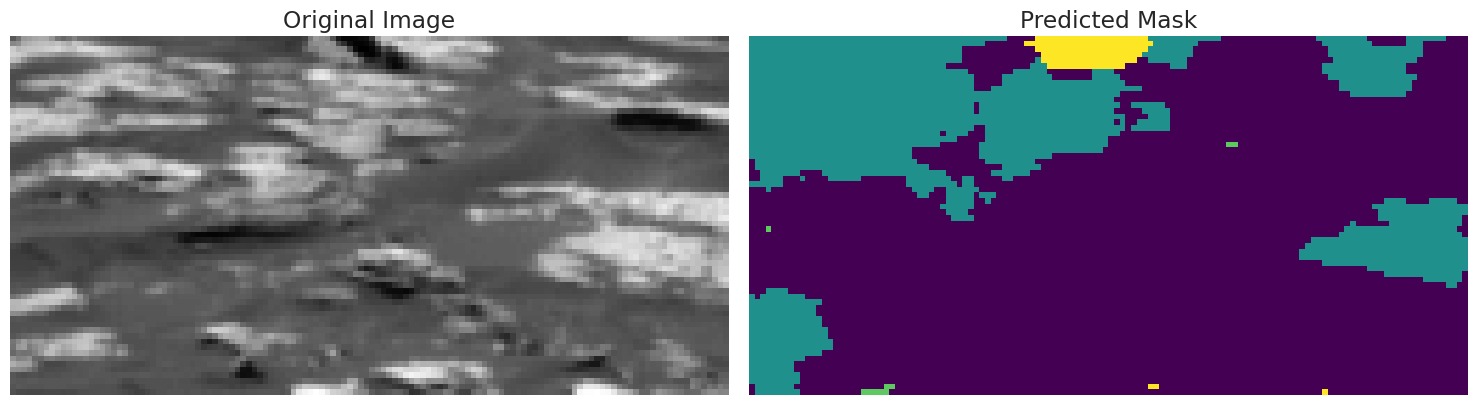

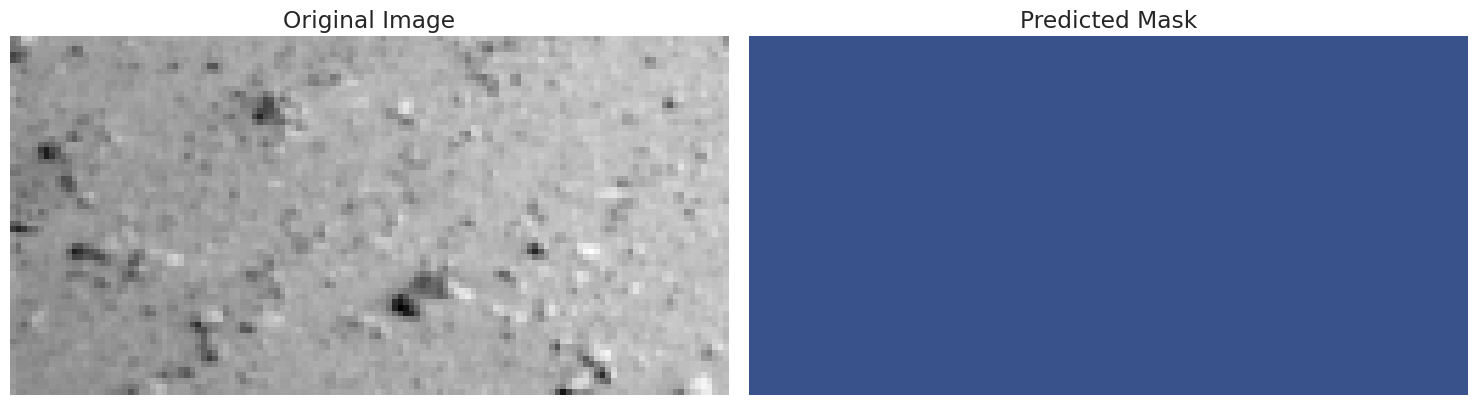

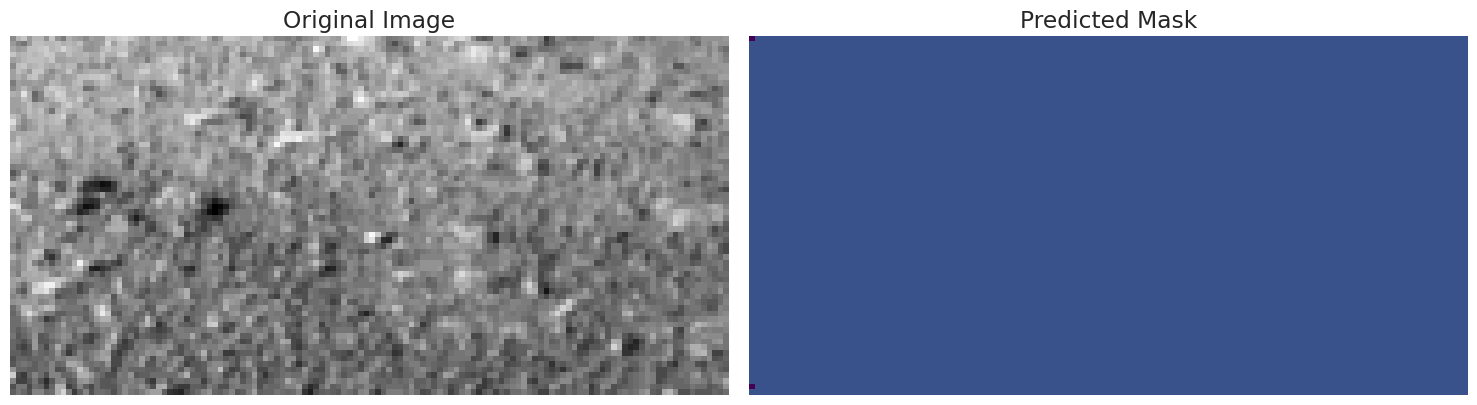

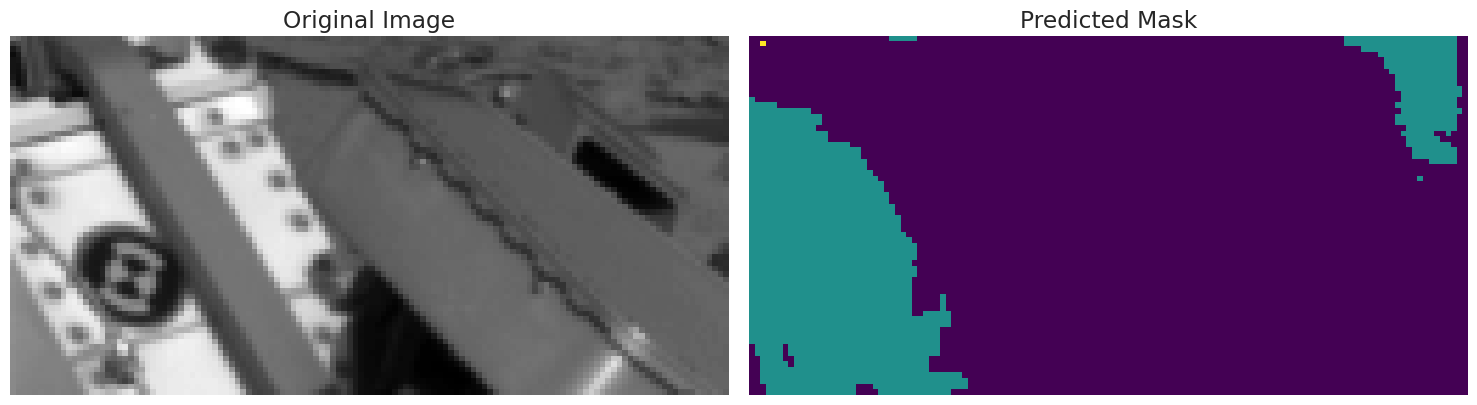

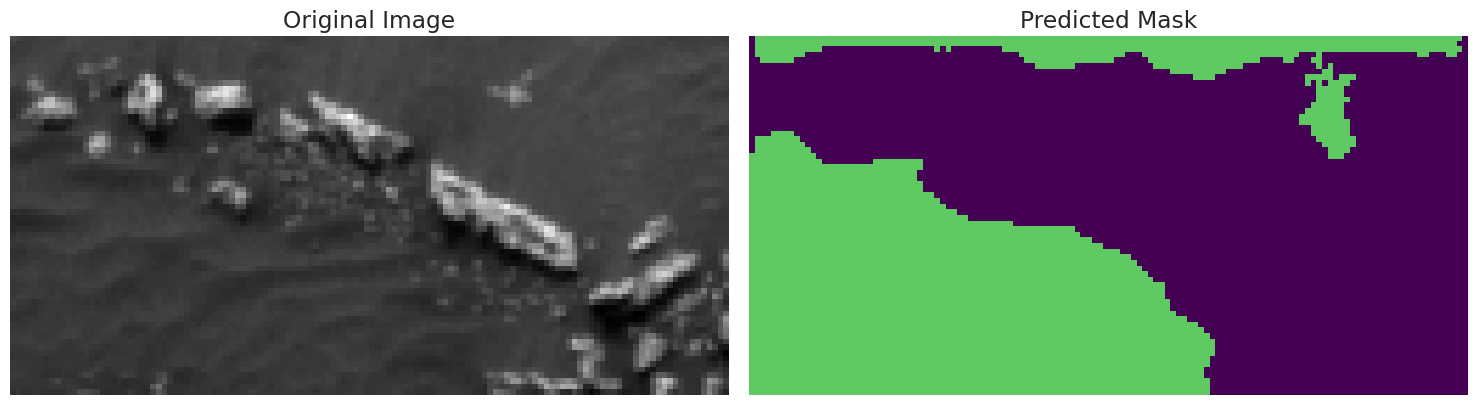

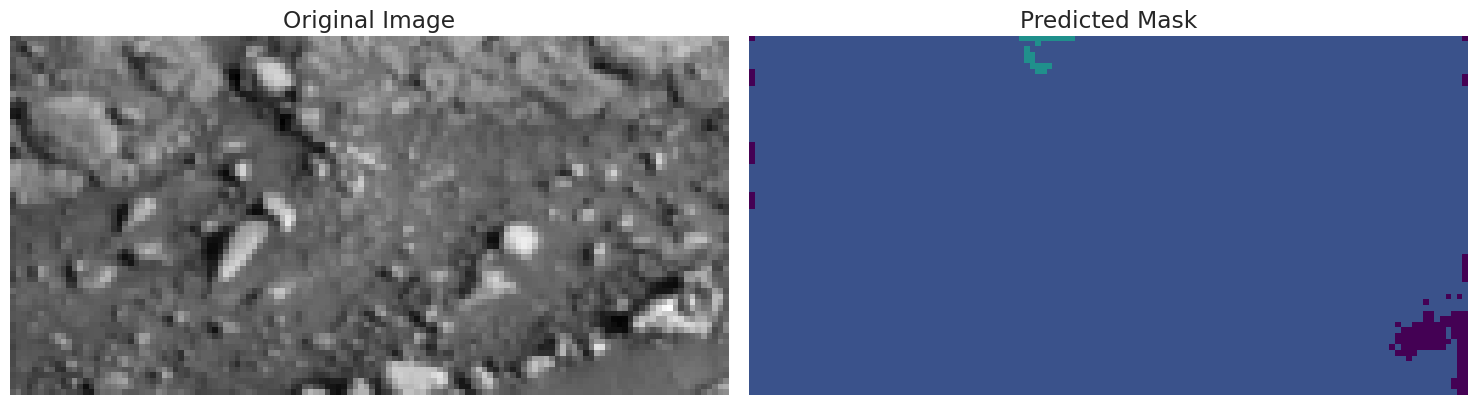

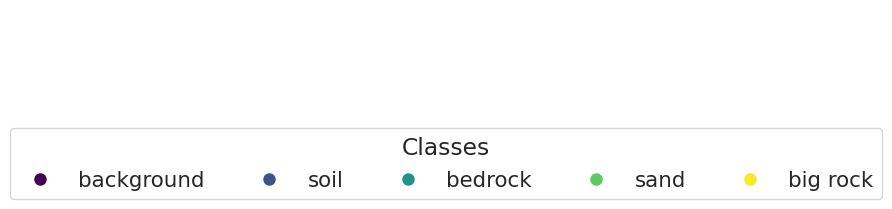

In [34]:
# Plot some predictions 
num_samples = 8
# Only take the first `num_samples` from X_test and preds
images = X_test[:num_samples]
predictions = preds[:num_samples]

# Adjust the number of classes to match the actual classes in the predictions (excluding 0)
num_classes = len(classes) # Excluding background

# Create colormap based on the number of classes
colormap = create_segmentation_colormap(num_classes)

# Create a list to store the handles for the legend (only once)
handles = []

for i in range(num_samples):
    # Get the i-th image and its prediction
    image = images[i]
    predicted_mask = predictions[i]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot original image
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis('off')

    # Plot predicted mask
    axes[1].set_title("Predicted Mask")
    colored_pred = apply_colormap(predicted_mask, colormap)
    axes[1].imshow(colored_pred)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# After all images have been plotted, add the legend once
# We collect handles for the legend here, only once
for label_idx in category_map: 
    color = colormap[label_idx]  # Use array indexing, subtracting 1 to account for class 0 exclusion
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=classes[label_idx]))

# Create a single legend displayed at the bottom
fig, ax = plt.subplots(figsize=(10, 2))  # Make the figure wide enough for a horizontal legend
ax.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, 0), title="Classes", ncol=len(category_map))
ax.axis('off')
plt.show()

In [35]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [36]:
# Create the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)